<a href="https://colab.research.google.com/github/Hakan1998/NYC-Taxi-Demand-Forecast/blob/main/Projektseminar__Forecast_Model_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0.Loading Packages and Data

In [ ]:
import os
import time
import math
import pickle
import warnings
import datetime
import numpy as np
import pandas as pd
import matplotlib
import seaborn as sns
import matplotlib.pylab as plt
import folium
import dask.dataframe as dd
import pandas as pd
import pyarrow.parquet as pq
import io
import requests
import gdown
from matplotlib import rcParams
from tqdm import tqdm
import time
from prettytable import PrettyTable
from datetime import datetime as d
import pyarrow.parquet as pq
import pandas as pd
import pandas.plotting as pd_plotting
from google.colab import drive
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import geopandas as gpd
from pyproj import CRS

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Data Preperation

Load Tripc Record Data from : https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page



*   Train Data - Januar 2009
*   Test Data - Februar 2009



In [ ]:
#load data

# Januar 2009
parquet_path_2009 = "/content/drive/MyDrive/Projektseminar/yellow_tripdata_2009-01.parquet"
data_train = pq.read_table(parquet_path_2009).to_pandas()

# Februar 2009
parquet_path_2009_02 = "/content/drive/MyDrive/Projektseminar/yellow_tripdata_2009-02.parquet"
data_test = pq.read_table(parquet_path_2009_02).to_pandas()

#parquet_path_2010 = "/content/drive/MyDrive/Projektseminar/yellow_tripdata_2010-01.parquet"
#data_test = pq.read_table(parquet_path_2010).to_pandas()



##0 cleaning Data
No need to search outliners outside of New York since we plan later to filter on only relevant zones anyway. So instead of looking for outliners and unnecessary columns we will later just pick the relevant data and and remove the rest. For now:


*   align column names of Train and Test Data
*   remove duplicates and missing data



In [ ]:
print(data_train.columns)
print(data_test.columns)

Index(['vendor_name', 'Trip_Pickup_DateTime', 'Trip_Dropoff_DateTime',
       'Passenger_Count', 'Trip_Distance', 'Start_Lon', 'Start_Lat',
       'Rate_Code', 'store_and_forward', 'End_Lon', 'End_Lat', 'Payment_Type',
       'Fare_Amt', 'surcharge', 'mta_tax', 'Tip_Amt', 'Tolls_Amt',
       'Total_Amt'],
      dtype='object')
Index(['vendor_name', 'Trip_Pickup_DateTime', 'Trip_Dropoff_DateTime',
       'Passenger_Count', 'Trip_Distance', 'Start_Lon', 'Start_Lat',
       'Rate_Code', 'store_and_forward', 'End_Lon', 'End_Lat', 'Payment_Type',
       'Fare_Amt', 'surcharge', 'mta_tax', 'Tip_Amt', 'Tolls_Amt',
       'Total_Amt'],
      dtype='object')


In [ ]:
# rename test data columns to train data columns
data_test.rename(columns={"pickup_datetime": "Trip_Pickup_DateTime",
                          "pickup_longitude": "Start_Lon",
                          "pickup_latitude": "Start_Lat",
                          "dropoff_longitude": "End_Lon",
                          "dropoff_latitude": "End_Lat"
                          }, inplace=True)

In [ ]:
def clean_duplicates_and_missing(df):
    """
    Check for duplicates and missing data in a DataFrame.
    Clean duplicates.
    """
    duplicates = df.duplicated().sum()
    missing_data = df.isnull().sum()

    cleaned_df = df.drop_duplicates(keep='first')

    result = {
        'duplicates': duplicates,
        'missing_data': missing_data
    }

    return cleaned_df, result

# Assuming 'data_train' and 'data_test' are your DataFrames
cleaned_data_train, result_train = clean_duplicates_and_missing(data_train)
cleaned_data_test, result_test = clean_duplicates_and_missing(data_test)

# Display the shape before and after cleaning for data_train
print("Shape of data_train before cleaning:", data_train.shape)
print("Shape of data_train after cleaning duplicates:", cleaned_data_train.shape)
print("\n")

# Display the shape before and after cleaning for data_test
print("Shape of data_test before cleaning:", data_test.shape)
print("Shape of data_test after cleaning duplicates:", cleaned_data_test.shape)
print("\n")

# Display the results for data_train
print("Results for data_train:")
print("Duplicates:", result_train['duplicates'])
print("Missing Data:\n", result_train['missing_data'])
print("\n")

# Display the results for data_test
print("Results for data_test:")
print("Duplicates:", result_test['duplicates'])
print("Missing Data:\n", result_test['missing_data'])

Shape of data_train before cleaning: (14092413, 18)
Shape of data_train after cleaning duplicates: (14092382, 18)


Shape of data_test before cleaning: (13380122, 18)
Shape of data_test after cleaning duplicates: (13380105, 18)


Results for data_train:
Duplicates: 31
Missing Data:
 vendor_name                     0
Trip_Pickup_DateTime            0
Trip_Dropoff_DateTime           0
Passenger_Count                 0
Trip_Distance                   0
Start_Lon                       0
Start_Lat                       0
Rate_Code                14092413
store_and_forward        14091189
End_Lon                         0
End_Lat                         0
Payment_Type                    0
Fare_Amt                        0
surcharge                       0
mta_tax                  14092413
Tip_Amt                         0
Tolls_Amt                       0
Total_Amt                       0
dtype: int64


Results for data_test:
Duplicates: 17
Missing Data:
 vendor_name                     0
Tr

## 1.1 Preprocessing

extract Infos from column pickup Datetime for Weekday and time hour with Monday = 0, Sunday = 6



* extract pickup day from datetime column with Monday = 0, Sunday = 6
* extract pick hour from datetime column



In [ ]:
data_train = cleaned_data_train
data_test = cleaned_data_test

def preprocess_datetime_columns(data):
    # Convert 'Trip_Pickup_DateTime' to datetime
    data['pickup_datetime'] = pd.to_datetime(data['Trip_Pickup_DateTime'])

    # Create additional columns for day name, day number, and hour
    data['pickup_day'] = data['pickup_datetime'].dt.day_name()
    data['pickup_day_no'] = data['pickup_datetime'].dt.weekday
    data['pickup_hour'] = data['pickup_datetime'].dt.hour

    return data

data_train = preprocess_datetime_columns(data_train.copy())
data_test = preprocess_datetime_columns(data_test.copy())


In [ ]:
display(data_train)

,vendor_name,Trip_Pickup_DateTime,Trip_Dropoff_DateTime,Passenger_Count,Trip_Distance,Start_Lon,Start_Lat,Rate_Code,store_and_forward,End_Lon,...,Fare_Amt,surcharge,mta_tax,Tip_Amt,Tolls_Amt,Total_Amt,pickup_datetime,pickup_day,pickup_day_no,pickup_hour
0,VTS,2009-01-04 02:52:00,2009-01-04 03:02:00,1,2.63,-73.991957,40.721567,NaN,NaN,-73.993803,...,8.9,0.5,NaN,0.00,0.0,9.40,2009-01-04 02:52:00,Sunday,6,2
1,VTS,2009-01-04 03:31:00,2009-01-04 03:38:00,3,4.55,-73.982102,40.736290,NaN,NaN,-73.955850,...,12.1,0.5,NaN,2.00,0.0,14.60,2009-01-04 03:31:00,Sunday,6,3
2,VTS,2009-01-03 15:43:00,2009-01-03 15:57:00,5,10.35,-74.002587,40.739748,NaN,NaN,-73.869983,...,23.7,0.0,NaN,4.74,0.0,28.44,2009-01-03 15:43:00,Saturday,5,15
3,DDS,2009-01-01 20:52:58,2009-01-01 21:14:00,1,5.00,-73.974267,40.790955,NaN,NaN,-73.996558,...,14.9,0.5,NaN,3.05,0.0,18.45,2009-01-01 20:52:58,Thursday,3,20
4,DDS,2009-01-24 16:18:23,2009-01-24 16:24:56,1,0.40,-74.001580,40.719382,NaN,NaN,-74.008378,...,3.7,0.0,NaN,0.00,0.0,3.70,2009-01-24 16:18:23,Saturday,5,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14092408,VTS,2009-01-27 14:36:00,2009-01-27 14:46:00,5,0.89,-73.982013,40.743330,NaN,NaN,-73.994328,...,6.5,0.0,NaN,0.00,0.0,6.50,2009-01-27 14:36:00,Tuesday,1,14
14092409,VTS,2009-01-27 13:56:00,2009-01-27 14:02:00,1,1.94,-73.972788,40.761988,NaN,NaN,-73.951477,...,8.1,0.0,NaN,1.90,0.0,10.00,2009-01-27 13:56:00,Tuesday,1,13
14092410,CMT,2009-01-23 08:39:44,2009-01-23 09:02:15,1,3.80,-73.977467,40.751861,NaN,NaN,-74.009913,...,14.5,0.0,NaN,0.00,0.0,14.50,2009-01-23 08:39:44,Friday,4,8
14092411,VTS,2009-01-24 23:05:00,2009-01-24 23:15:00,3,3.85,-73.981295,40.753000,NaN,NaN,-73.949453,...,10.9,0.5,NaN,0.00,0.0,11.40,2009-01-24 23:05:00,Saturday,5,23


## 1.2 Spatial Analysis

In the next step, we now want to know in which region how many pickups took place

Since colab hasnt enough RAM for the following steps we need to clean all variables exept train and test data

In [ ]:
%reset_selective -f ^(?!data_train$|data_test$).*

Variable     Type         Data/Info
-----------------------------------
data_test    DataFrame             vendor_id Trip_P<...>863762 rows x 22 columns]
data_train   DataFrame             vendor_name Trip<...>092382 rows x 22 columns]


now we Check the Data and the given Shapefile of New York City also from the TlC website as the data

In [ ]:
shapefile_path = "/content/drive/MyDrive/Projektseminar/taxi_zones/taxi_zones.shp"
gdf = gpd.read_file(shapefile_path)
display(gdf.head(2))
display(data_train.head(2))

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19..."
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((1033269.244 172126.008, 103343..."


,vendor_name,Trip_Pickup_DateTime,Trip_Dropoff_DateTime,Passenger_Count,Trip_Distance,Start_Lon,Start_Lat,Rate_Code,store_and_forward,End_Lon,...,Fare_Amt,surcharge,mta_tax,Tip_Amt,Tolls_Amt,Total_Amt,pickup_datetime,pickup_day,pickup_day_no,pickup_hour
0,VTS,2009-01-04 02:52:00,2009-01-04 03:02:00,1,2.63,-73.991957,40.721567,NaN,NaN,-73.993803,...,8.9,0.5,NaN,0.0,0.0,9.4,2009-01-04 02:52:00,Sunday,6,2
1,VTS,2009-01-04 03:31:00,2009-01-04 03:38:00,3,4.55,-73.982102,40.736290,NaN,NaN,-73.955850,...,12.1,0.5,NaN,2.0,0.0,14.6,2009-01-04 03:31:00,Sunday,6,3


As we can see our Shapefile geometry doesnt match our Data form since we have Latitude and Longitude and the Shapefile has Polygon and Multipolygon form. The goal is to add the zone and borough Info from the shapefile to our data so we can see which trip did hapen in which place.


Now merge Shapefile Data with our Data with an spatial Join to match our Latitude and Longitude to the Polygon Form
from the New York Shapefile


---

Important:
- We need the same CRS (Geographic coordinate Sytem) on both Datasets
- Then we make a spatial Join to add the Shapefile Information to our Data

First for Train data since the spatial join is strongly Memory-intensive and cant be done on both datasets at the same time.
So again clean storage first:

In [ ]:
data = data_train
%reset_selective -f data

In [ ]:
print(data_train.columns)

Index(['vendor_name', 'Trip_Pickup_DateTime', 'Trip_Dropoff_DateTime',
       'Passenger_Count', 'Trip_Distance', 'Start_Lon', 'Start_Lat',
       'Rate_Code', 'store_and_forward', 'End_Lon', 'End_Lat', 'Payment_Type',
       'Fare_Amt', 'surcharge', 'mta_tax', 'Tip_Amt', 'Tolls_Amt', 'Total_Amt',
       'pickup_datetime', 'pickup_day', 'pickup_day_no', 'pickup_hour'],
      dtype='object')


Align the CRS, do the spatial join, create the Geo point and then only select the important columns since we are only interest in the amount of Trips in each Region.

In [ ]:
data = data_train

shapefile_path = "/content/drive/MyDrive/Projektseminar/taxi_zones/taxi_zones.shp"
gdf = gpd.read_file(shapefile_path)

# Load the Shapefile with zones
gdf_zones = gpd.read_file(shapefile_path)
gdf_zones = gdf_zones.to_crs('EPSG:4326')  # Transform to EPSG:4326 for consistent coordinate comparison

# Load data into a GeoDataFrame
gdf_taxi = gpd.GeoDataFrame(data_train, geometry=gpd.points_from_xy(data['Start_Lon'], data['Start_Lat']))

# Define the CRS for EPSG:4326
crs = CRS.from_epsg(4326)

# Set the CRS for gdf_taxi
gdf_taxi.crs = crs

taxi_with_zones = gpd.sjoin(gdf_taxi, gdf_zones, how='left', op='within')

# Display the resulting GeoDataFrame
display(taxi_with_zones.head(2))

df = taxi_with_zones
selected_columns = df[["Trip_Pickup_DateTime", "pickup_day", "pickup_hour", "Start_Lon", "Start_Lat", "geometry", "zone", "borough"]]
selected_columns.rename(columns={'geometry': 'geo_point'}, inplace=True)

result_df = pd.merge(selected_columns, gdf[['zone', 'borough', 'geometry']], on=['zone', 'borough'], how='left')
display(result_df)

df = taxi_with_zones
selected_columns = df[["Trip_Pickup_DateTime", "pickup_day", "pickup_hour", "Start_Lon", "Start_Lat", "geometry", "zone", "borough"]]
selected_columns.rename(columns={'geometry': 'geo_point'}, inplace=True)

result_df = pd.merge(selected_columns, gdf[['zone', 'borough', 'geometry']], on=['zone', 'borough'], how='left')
display(result_df)

df = result_df

# lets remove unneccassary columns
df = taxi_with_zones
selected_columns = df[["Trip_Pickup_DateTime", "pickup_day", "pickup_hour", "Start_Lon", "Start_Lat", "geometry", "zone", "borough"]]
selected_columns.rename(columns={'geometry': 'geo_point'}, inplace=True)

result_df = pd.merge(selected_columns, gdf[['zone', 'borough', 'geometry']], on=['zone', 'borough'], how='left')
display(result_df)

to sum this up as an function:

In [ ]:
def process_taxi_data(data_train, shapefile_path):
    gdf_zones = gpd.read_file(shapefile_path).to_crs('EPSG:4326')
    gdf_taxi = gpd.GeoDataFrame(data_train, geometry=gpd.points_from_xy(data_train['Start_Lon'], data_train['Start_Lat']))
    gdf_taxi.crs = "EPSG:4326"
    taxi_with_zones = gpd.sjoin(gdf_taxi, gdf_zones, how='left', op='within')
    result_df = pd.merge(taxi_with_zones[["Trip_Pickup_DateTime", "pickup_day", "pickup_hour", "Start_Lon", "Start_Lat", "geometry", "zone", "borough"]].rename(columns={'geometry': 'geo_point'}),
                             gdf_zones[['zone', 'borough', 'geometry']], on=['zone', 'borough'], how='left')
    return result_df

As a result we can see the zone and borough for each geopoint of all our pickup locations

In [ ]:
data_train = result_df
display(data_train)

,Trip_Pickup_DateTime,pickup_day,pickup_hour,Start_Lon,Start_Lat,geo_point,zone,borough,geometry
0,2009-01-04 02:52:00,Sunday,2,-73.991957,40.721567,POINT (-73.99196 40.72157),Lower East Side,Manhattan,"POLYGON ((988552.836 201677.665, 988387.669 20..."
1,2009-01-04 03:31:00,Sunday,3,-73.982102,40.736290,POINT (-73.98210 40.73629),Gramercy,Manhattan,"POLYGON ((989131.643 205749.904, 989084.531 20..."
2,2009-01-03 15:43:00,Saturday,15,-74.002587,40.739748,POINT (-74.00259 40.73975),West Village,Manhattan,"POLYGON ((983555.319 204876.901, 983469.158 20..."
3,2009-01-01 20:52:58,Thursday,20,-73.974267,40.790955,POINT (-73.97427 40.79095),Upper West Side North,Manhattan,"POLYGON ((992877.880 225627.534, 992741.735 22..."
4,2009-01-24 16:18:23,Saturday,16,-74.001580,40.719382,POINT (-74.00158 40.71938),Little Italy/NoLiTa,Manhattan,"POLYGON ((985411.760 200369.518, 985342.573 20..."
...,...,...,...,...,...,...,...,...,...
14093470,2009-01-27 14:36:00,Tuesday,14,-73.982013,40.743330,POINT (-73.98201 40.74333),Murray Hill,Manhattan,"POLYGON ((991999.299 210994.739, 991972.635 21..."
14093471,2009-01-27 13:56:00,Tuesday,13,-73.972788,40.761988,POINT (-73.97279 40.76199),Midtown North,Manhattan,"POLYGON ((989412.663 219020.943, 990045.841 21..."
14093472,2009-01-23 08:39:44,Friday,8,-73.977467,40.751861,POINT (-73.97747 40.75186),Murray Hill,Manhattan,"POLYGON ((991999.299 210994.739, 991972.635 21..."
14093473,2009-01-24 23:05:00,Saturday,23,-73.981295,40.753000,POINT (-73.98130 40.75300),Midtown South,Manhattan,"POLYGON ((988787.425 210315.593, 988662.868 21..."


Now we can see which trip did happen in which Region or Zone of New York City. Lets analyze this:

- Since we have over 13 Million Trips we sample 10.000 for better visualisation

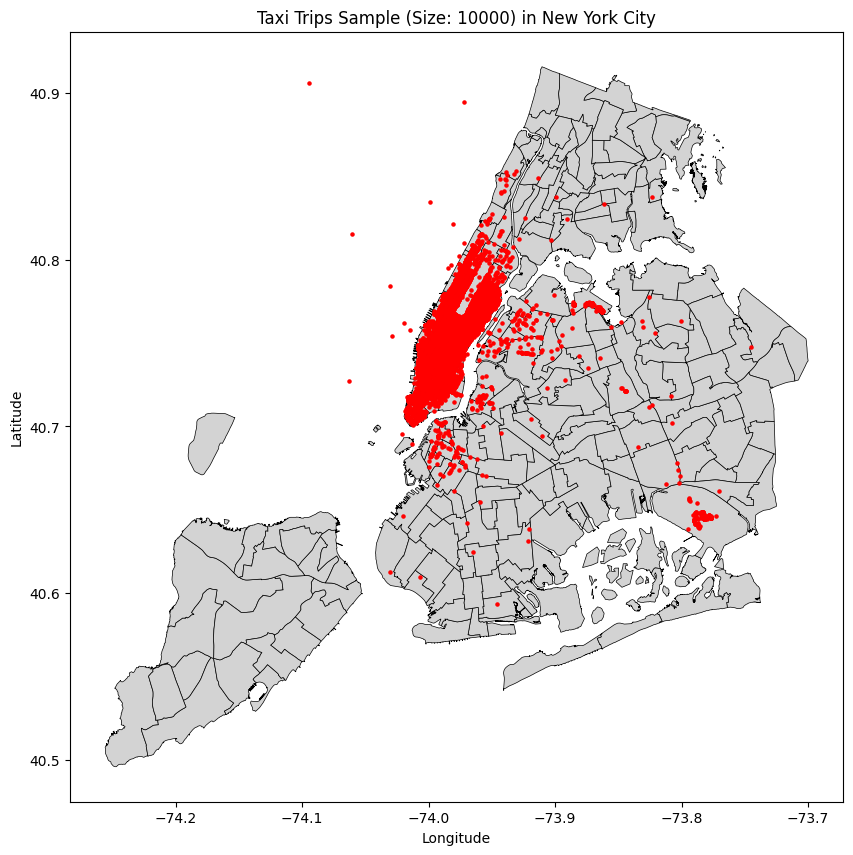

,borough,data_points_count,percentage
0,Manhattan,12580987,94.203495
1,Queens,512399,3.836724
2,Brooklyn,208117,1.558332
3,Bronx,11478,0.085945
4,Staten Island,569,0.004261


In [ ]:
data = data_train
shapefile_path = "/content/drive/MyDrive/Projektseminar/taxi_zones/taxi_zones.shp"
nyc_map = gpd.read_file(shapefile_path)
nyc_map = nyc_map.to_crs(epsg=4326)

# Konvertiere den DataFrame in einen GeoDataFrame und setze das CRS auf EPSG:4326
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['Start_Lon'], df['Start_Lat']), crs=4326)

# Reduziere die Anzahl der Punkte auf eine Stichprobe von 10.000
sample_size = 10000
gdf_sample = gdf.sample(sample_size, random_state=42)

# Plot auf einer Karte von New York City
fig, ax = plt.subplots(figsize=(10, 10))
nyc_map.plot(ax=ax, color='lightgrey', linewidth=0.5, edgecolor='k')

# Plotte die reduzierte Stichprobe der Punkte
ax.scatter(gdf_sample['geometry'].x, gdf_sample['geometry'].y, marker='o', color='red', s=5)

# Setze Achsenbeschriftungen und Titel direkt im Plot
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title(f'Taxi Trips Sample (Size: {sample_size}) in New York City')

# Zeige den Plot an
plt.show()

# Calculate the overall percentage for each borough
borough_percentage = (df['borough'].value_counts() / len(df)) * 100

# Create a DataFrame with borough counts and percentages
borough_counts = df['borough'].value_counts().reset_index()
borough_counts.columns = ['borough', 'data_points_count']

# Merge with the percentage data
borough_counts = pd.merge(borough_counts, pd.DataFrame({'borough': borough_percentage.index, 'percentage': borough_percentage.values}), on='borough')

# Display the resulting DataFrame
display(borough_counts)

As we can see over 94% of Pickup trips happen in Manhatten, we reduce our Forecast to Manhatten.

Filter Data to only Manhattan:

In [ ]:
df_manhattan = result_df[result_df['borough'] == 'Manhattan']

## 1.3 Time Binning

Now count the Pickups of each zone in Manhatten. Lets start with an hourly time Binning.

1 hour Time Binning

In [ ]:
df = data_train[data_train['borough'] == 'Manhattan']

def one_hour_time_binning(data_frame):
    # Convert 'Trip_Pickup_DateTime' to datetime
    data_frame['Trip_Pickup_DateTime'] = pd.to_datetime(data_frame['Trip_Pickup_DateTime'])

    # Define the time bins (1-hour intervals)
    time_bins = pd.date_range(start=data_frame['Trip_Pickup_DateTime'].min(), end=data_frame['Trip_Pickup_DateTime'].max(), freq='1H')

    # Create a new column 'time_bin' based on the time bins
    data_frame['time_bin'] = pd.cut(data_frame['Trip_Pickup_DateTime'], bins=time_bins, labels=time_bins[:-1])

    # Group by 'zone' and 'time_bin' and count the number of trips in each group
    processed_data = data_frame.groupby(['zone', 'time_bin']).size().reset_index(name='demand')

    return processed_data

df = data_train_manhattan
result_df = one_hour_time_binning(df)

# Display the resulting DataFrame
display(result_df)



/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,zone,time_bin,demand
0,Alphabet City,2009-01-01 00:00:00,121
1,Alphabet City,2009-01-01 01:00:00,138
2,Alphabet City,2009-01-01 02:00:00,124
3,Alphabet City,2009-01-01 03:00:00,124
4,Alphabet City,2009-01-01 04:00:00,100
...,...,...,...
49776,Yorkville West,2009-01-31 18:00:00,784
49777,Yorkville West,2009-01-31 19:00:00,851
49778,Yorkville West,2009-01-31 20:00:00,812
49779,Yorkville West,2009-01-31 21:00:00,854


Now the same for test data

clean the RAM again

In [ ]:
%reset_selective -f ^(?!data_test$).*
import gc

# Perform garbage collection to release memory
gc.collect()

0

In [ ]:
data = data_test

shapefile_path = "/content/drive/MyDrive/Projektseminar/taxi_zones/taxi_zones.shp"
gdf = gpd.read_file(shapefile_path)

# Load the Shapefile with zones
gdf_zones = gpd.read_file(shapefile_path)
gdf_zones = gdf_zones.to_crs('EPSG:4326')  # Transform to EPSG:4326 for consistent coordinate comparison

# Load data into a GeoDataFrame
gdf_taxi = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data['Start_Lon'], data['Start_Lat']))

# Define the CRS for EPSG:4326
crs = CRS.from_epsg(4326)

# Set the CRS for gdf_taxi
gdf_taxi.crs = crs

taxi_with_zones = gpd.sjoin(gdf_taxi, gdf_zones, how='left', op='within')

# Display the resulting GeoDataFrame
display(taxi_with_zones.head(2))

df = taxi_with_zones
selected_columns = df[["Trip_Pickup_DateTime", "pickup_day", "pickup_hour", "Start_Lon", "Start_Lat", "geometry", "zone", "borough"]]
selected_columns.rename(columns={'geometry': 'geo_point'}, inplace=True)

result_df = pd.merge(selected_columns, gdf[['zone', 'borough', 'geometry']], on=['zone', 'borough'], how='left')
display(result_df)

df = taxi_with_zones
selected_columns = df[["Trip_Pickup_DateTime", "pickup_day", "pickup_hour", "Start_Lon", "Start_Lat", "geometry", "zone", "borough"]]
selected_columns.rename(columns={'geometry': 'geo_point'}, inplace=True)

result_df = pd.merge(selected_columns, gdf[['zone', 'borough', 'geometry']], on=['zone', 'borough'], how='left')
display(result_df)

df = result_df

# lets remove unneccassary columns
df = taxi_with_zones
selected_columns = df[["Trip_Pickup_DateTime", "pickup_day", "pickup_hour", "Start_Lon", "Start_Lat", "geometry", "zone", "borough"]]
selected_columns.rename(columns={'geometry': 'geo_point'}, inplace=True)

result_df = pd.merge(selected_columns, gdf[['zone', 'borough', 'geometry']], on=['zone', 'borough'], how='left')
display(result_df)

,vendor_name,Trip_Pickup_DateTime,Trip_Dropoff_DateTime,Passenger_Count,Trip_Distance,Start_Lon,Start_Lat,Rate_Code,store_and_forward,End_Lon,...,pickup_day_no,pickup_hour,geometry,index_right,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough
0,DDS,2009-02-03 08:25:00,2009-02-03 08:33:39,1,1.60,-73.992768,40.758325,NaN,NaN,-73.99471,...,1,8,POINT (-73.99277 40.75832),47.0,48.0,0.043747,0.000094,Clinton East,48.0,Manhattan
1,VTS,2009-02-28 00:26:00,2009-02-28 00:40:00,5,3.05,0.000000,0.000000,NaN,NaN,0.00000,...,5,0,POINT (0.00000 0.00000),NaN,NaN,NaN,NaN,NaN,NaN,NaN


,Trip_Pickup_DateTime,pickup_day,pickup_hour,Start_Lon,Start_Lat,geo_point,zone,borough,geometry
0,2009-02-03 08:25:00,Tuesday,8,-73.992768,40.758325,POINT (-73.99277 40.75832),Clinton East,Manhattan,"POLYGON ((986694.313 214463.846, 986568.184 21..."
1,2009-02-28 00:26:00,Saturday,0,0.000000,0.000000,POINT (0.00000 0.00000),NaN,NaN,None
2,2009-02-22 00:39:23,Sunday,0,-73.137393,41.366138,POINT (-73.13739 41.36614),NaN,NaN,None
3,2009-02-28 12:47:00,Saturday,12,-73.980458,40.748445,POINT (-73.98046 40.74844),Murray Hill,Manhattan,"POLYGON ((991999.299 210994.739, 991972.635 21..."
4,2009-02-05 18:34:35,Thursday,18,-73.137393,41.366138,POINT (-73.13739 41.36614),NaN,NaN,None
...,...,...,...,...,...,...,...,...,...
13382103,2009-02-01 17:09:40,Sunday,17,-73.970121,40.748764,POINT (-73.97012 40.74876),UN/Turtle Bay South,Manhattan,"MULTIPOLYGON (((993816.792 213230.430, 993857...."
13382104,2009-02-03 13:13:43,Tuesday,13,-73.985543,40.752639,POINT (-73.98554 40.75264),Midtown South,Manhattan,"POLYGON ((988787.425 210315.593, 988662.868 21..."
13382105,2009-02-01 15:51:00,Sunday,15,-73.975309,40.733122,POINT (-73.97531 40.73312),Stuy Town/Peter Cooper Village,Manhattan,"POLYGON ((991147.703 207200.071, 991189.448 20..."
13382106,2009-02-07 01:33:43,Saturday,1,-73.972443,40.754235,POINT (-73.97244 40.75424),Midtown East,Manhattan,"POLYGON ((992224.354 214415.293, 992096.999 21..."


,Trip_Pickup_DateTime,pickup_day,pickup_hour,Start_Lon,Start_Lat,geo_point,zone,borough,geometry
0,2009-02-03 08:25:00,Tuesday,8,-73.992768,40.758325,POINT (-73.99277 40.75832),Clinton East,Manhattan,"POLYGON ((986694.313 214463.846, 986568.184 21..."
1,2009-02-28 00:26:00,Saturday,0,0.000000,0.000000,POINT (0.00000 0.00000),NaN,NaN,None
2,2009-02-22 00:39:23,Sunday,0,-73.137393,41.366138,POINT (-73.13739 41.36614),NaN,NaN,None
3,2009-02-28 12:47:00,Saturday,12,-73.980458,40.748445,POINT (-73.98046 40.74844),Murray Hill,Manhattan,"POLYGON ((991999.299 210994.739, 991972.635 21..."
4,2009-02-05 18:34:35,Thursday,18,-73.137393,41.366138,POINT (-73.13739 41.36614),NaN,NaN,None
...,...,...,...,...,...,...,...,...,...
13382103,2009-02-01 17:09:40,Sunday,17,-73.970121,40.748764,POINT (-73.97012 40.74876),UN/Turtle Bay South,Manhattan,"MULTIPOLYGON (((993816.792 213230.430, 993857...."
13382104,2009-02-03 13:13:43,Tuesday,13,-73.985543,40.752639,POINT (-73.98554 40.75264),Midtown South,Manhattan,"POLYGON ((988787.425 210315.593, 988662.868 21..."
13382105,2009-02-01 15:51:00,Sunday,15,-73.975309,40.733122,POINT (-73.97531 40.73312),Stuy Town/Peter Cooper Village,Manhattan,"POLYGON ((991147.703 207200.071, 991189.448 20..."
13382106,2009-02-07 01:33:43,Saturday,1,-73.972443,40.754235,POINT (-73.97244 40.75424),Midtown East,Manhattan,"POLYGON ((992224.354 214415.293, 992096.999 21..."


,Trip_Pickup_DateTime,pickup_day,pickup_hour,Start_Lon,Start_Lat,geo_point,zone,borough,geometry
0,2009-02-03 08:25:00,Tuesday,8,-73.992768,40.758325,POINT (-73.99277 40.75832),Clinton East,Manhattan,"POLYGON ((986694.313 214463.846, 986568.184 21..."
1,2009-02-28 00:26:00,Saturday,0,0.000000,0.000000,POINT (0.00000 0.00000),NaN,NaN,None
2,2009-02-22 00:39:23,Sunday,0,-73.137393,41.366138,POINT (-73.13739 41.36614),NaN,NaN,None
3,2009-02-28 12:47:00,Saturday,12,-73.980458,40.748445,POINT (-73.98046 40.74844),Murray Hill,Manhattan,"POLYGON ((991999.299 210994.739, 991972.635 21..."
4,2009-02-05 18:34:35,Thursday,18,-73.137393,41.366138,POINT (-73.13739 41.36614),NaN,NaN,None
...,...,...,...,...,...,...,...,...,...
13382103,2009-02-01 17:09:40,Sunday,17,-73.970121,40.748764,POINT (-73.97012 40.74876),UN/Turtle Bay South,Manhattan,"MULTIPOLYGON (((993816.792 213230.430, 993857...."
13382104,2009-02-03 13:13:43,Tuesday,13,-73.985543,40.752639,POINT (-73.98554 40.75264),Midtown South,Manhattan,"POLYGON ((988787.425 210315.593, 988662.868 21..."
13382105,2009-02-01 15:51:00,Sunday,15,-73.975309,40.733122,POINT (-73.97531 40.73312),Stuy Town/Peter Cooper Village,Manhattan,"POLYGON ((991147.703 207200.071, 991189.448 20..."
13382106,2009-02-07 01:33:43,Saturday,1,-73.972443,40.754235,POINT (-73.97244 40.75424),Midtown East,Manhattan,"POLYGON ((992224.354 214415.293, 992096.999 21..."


In [ ]:
data_test = result_df
display(data_test)

data_test_manhattan = data_test[data_test['borough'] == 'Manhattan']

,Trip_Pickup_DateTime,pickup_day,pickup_hour,Start_Lon,Start_Lat,geo_point,zone,borough,geometry
0,2009-02-03 08:25:00,Tuesday,8,-73.992768,40.758325,POINT (-73.99277 40.75832),Clinton East,Manhattan,"POLYGON ((986694.313 214463.846, 986568.184 21..."
1,2009-02-28 00:26:00,Saturday,0,0.000000,0.000000,POINT (0.00000 0.00000),NaN,NaN,None
2,2009-02-22 00:39:23,Sunday,0,-73.137393,41.366138,POINT (-73.13739 41.36614),NaN,NaN,None
3,2009-02-28 12:47:00,Saturday,12,-73.980458,40.748445,POINT (-73.98046 40.74844),Murray Hill,Manhattan,"POLYGON ((991999.299 210994.739, 991972.635 21..."
4,2009-02-05 18:34:35,Thursday,18,-73.137393,41.366138,POINT (-73.13739 41.36614),NaN,NaN,None
...,...,...,...,...,...,...,...,...,...
13382103,2009-02-01 17:09:40,Sunday,17,-73.970121,40.748764,POINT (-73.97012 40.74876),UN/Turtle Bay South,Manhattan,"MULTIPOLYGON (((993816.792 213230.430, 993857...."
13382104,2009-02-03 13:13:43,Tuesday,13,-73.985543,40.752639,POINT (-73.98554 40.75264),Midtown South,Manhattan,"POLYGON ((988787.425 210315.593, 988662.868 21..."
13382105,2009-02-01 15:51:00,Sunday,15,-73.975309,40.733122,POINT (-73.97531 40.73312),Stuy Town/Peter Cooper Village,Manhattan,"POLYGON ((991147.703 207200.071, 991189.448 20..."
13382106,2009-02-07 01:33:43,Saturday,1,-73.972443,40.754235,POINT (-73.97244 40.75424),Midtown East,Manhattan,"POLYGON ((992224.354 214415.293, 992096.999 21..."


In [ ]:
df = data_test_manhattan

# 1 Hour Time Binning

df['Trip_Pickup_DateTime'] = pd.to_datetime(df['Trip_Pickup_DateTime'])

# Define the time bins (1-hour intervals)
time_bins = pd.date_range(start=df['Trip_Pickup_DateTime'].min(), end=df['Trip_Pickup_DateTime'].max(), freq='1H')

# Create a new column 'time_bin' based on the time bins
df['time_bin'] = pd.cut(df['Trip_Pickup_DateTime'], bins=time_bins, labels=time_bins[:-1])

# Group by 'zone' and 'time_bin' and count the number of trips in each group
data_test_1Hour = df.groupby(['zone', 'time_bin']).size().reset_index(name='demand')

# Display the resulting DataFrame
display(data_test_1Hour)


data_test_1Hour.to_parquet('/content/drive/My Drive/Projektseminar/data_test_200902_1Hour.parquet', index=False)

,zone,time_bin,demand
0,Alphabet City,2009-02-01 00:00:00,348
1,Alphabet City,2009-02-01 01:00:00,375
2,Alphabet City,2009-02-01 02:00:00,432
3,Alphabet City,2009-02-01 03:00:00,291
4,Alphabet City,2009-02-01 04:00:00,212
...,...,...,...
44952,Yorkville West,2009-02-28 18:00:00,734
44953,Yorkville West,2009-02-28 19:00:00,787
44954,Yorkville West,2009-02-28 20:00:00,830
44955,Yorkville West,2009-02-28 21:00:00,815


# 2.EDA on 1 Hour and whole Manhattan

To see which Forecast model will work we analyze our data for Stationary, Trends and Seasonality.
First we wanna see the statistics for the whole data and after detect differences between each zones


### A Analyze for Stationary, Trends and Seasonality

load saved data

In [ ]:
file_path = '/content/drive/My Drive/Projektseminar/1Hour_Demand.parquet'
data = pd.read_parquet(file_path)
print(data)

                 zone            time_bin  demand
0       Alphabet City 2009-01-01 00:00:00     120
1       Alphabet City 2009-01-01 01:00:00     138
2       Alphabet City 2009-01-01 02:00:00     124
3       Alphabet City 2009-01-01 03:00:00     123
4       Alphabet City 2009-01-01 04:00:00      99
...               ...                 ...     ...
49776  Yorkville West 2009-01-31 18:00:00     769
49777  Yorkville West 2009-01-31 19:00:00     821
49778  Yorkville West 2009-01-31 20:00:00     796
49779  Yorkville West 2009-01-31 21:00:00     819
49780  Yorkville West 2009-01-31 22:00:00     822

[49781 rows x 3 columns]


break down the time-bin column to day and hour because its difficult to work with the datetime form

In [ ]:
df = pd.DataFrame(data)

# Konvertiere die Spalte 'time_bin' in ein datetime-Objekt
df['time_bin'] = pd.to_datetime(df['time_bin'])

# Kombiniere Tag und Stunde zu einer neuen Zeitkomponente
df['date'] = df['time_bin'].dt.strftime('%d-%H')

# Lösche die ursprüngliche time_combined-Spalte (optional)
df = df.drop(columns=['time_bin'])

# Zeige das aktualisierte DataFrame an
df_day_hour= df[['zone', 'date', 'demand']]
print(df_day_hour)

                 zone   date  demand
0       Alphabet City  01-00     120
1       Alphabet City  01-01     138
2       Alphabet City  01-02     124
3       Alphabet City  01-03     123
4       Alphabet City  01-04      99
...               ...    ...     ...
49776  Yorkville West  31-18     769
49777  Yorkville West  31-19     821
49778  Yorkville West  31-20     796
49779  Yorkville West  31-21     819
49780  Yorkville West  31-22     822

[49781 rows x 3 columns]
                 zone  demand  day  hour time_combined   date
0       Alphabet City     120    1     0         01-00  01-00
1       Alphabet City     138    1     1         01-01  01-01
2       Alphabet City     124    1     2         01-02  01-02
3       Alphabet City     123    1     3         01-03  01-03
4       Alphabet City      99    1     4         01-04  01-04
...               ...     ...  ...   ...           ...    ...
49776  Yorkville West     769   31    18         31-18  31-18
49777  Yorkville West     821   31

sum up the demand for all zones for each day and hour

In [ ]:
df = df_day_hour
groupedDate_df = df.groupby('date')['demand'].sum().reset_index()

# Zeige das aktualisierte DataFrame an
print(groupedDate_df)

      date  demand
0    01-00   13944
1    01-01   14830
2    01-02   13312
3    01-03   11389
4    01-04    8122
..     ...     ...
738  31-18   28995
739  31-19   32108
740  31-20   28113
741  31-21   27478
742  31-22   30176

[743 rows x 2 columns]


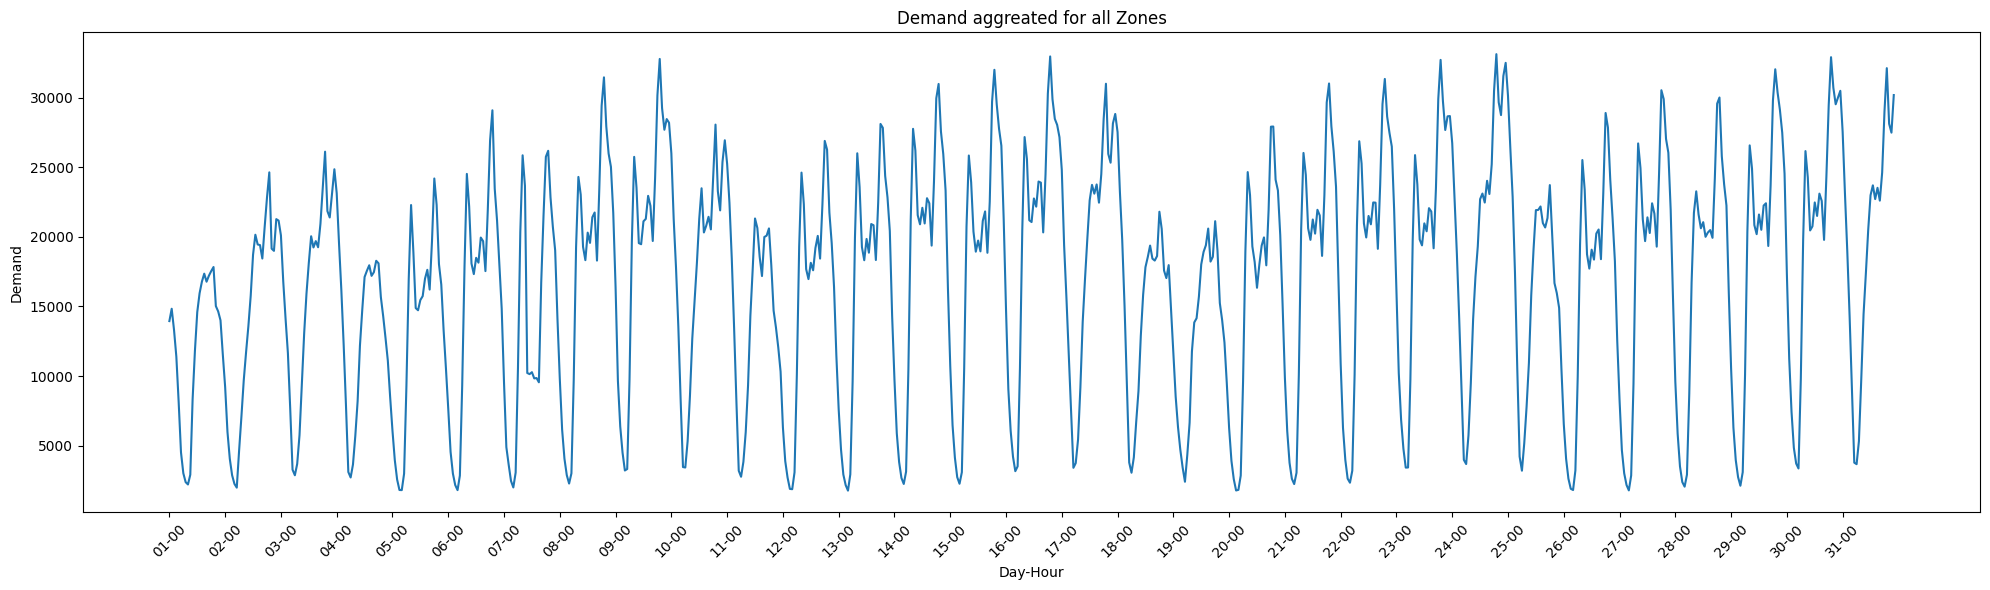

In [ ]:
# Plot
plt.figure(figsize=(20, 6))
plt.plot(groupedDate_df['date'], groupedDate_df['demand'], linestyle='-')

# Nur jeden n-ten Eintrag auf der x-Achse anzeigen (in diesem Fall jeden 24.)
n = 24
plt.xticks(range(0, len(grouped_df['date']), n), grouped_df['date'][::n], rotation=45)

plt.title('Demand aggreated for all Zones')
plt.xlabel('Day-Hour')
plt.ylabel('Demand')
plt.tight_layout()

# Zeige den Plot an
plt.show()

Decomposition

In [ ]:
df = data
# Convert 'time_bin' to datetime format
df['time_bin'] = pd.to_datetime(df['time_bin'])

# Group by 'time_bin' and 'zone', and calculate the sum of demand for each group
grouped_df = df.groupby([ 'time_bin'])['demand'].sum().reset_index()

# Display the grouped DataFrame
print(grouped_df)

               time_bin  demand
0   2009-01-01 00:00:00   13944
1   2009-01-01 01:00:00   14830
2   2009-01-01 02:00:00   13312
3   2009-01-01 03:00:00   11389
4   2009-01-01 04:00:00    8122
..                  ...     ...
738 2009-01-31 18:00:00   28995
739 2009-01-31 19:00:00   32108
740 2009-01-31 20:00:00   28113
741 2009-01-31 21:00:00   27478
742 2009-01-31 22:00:00   30176

[743 rows x 2 columns]


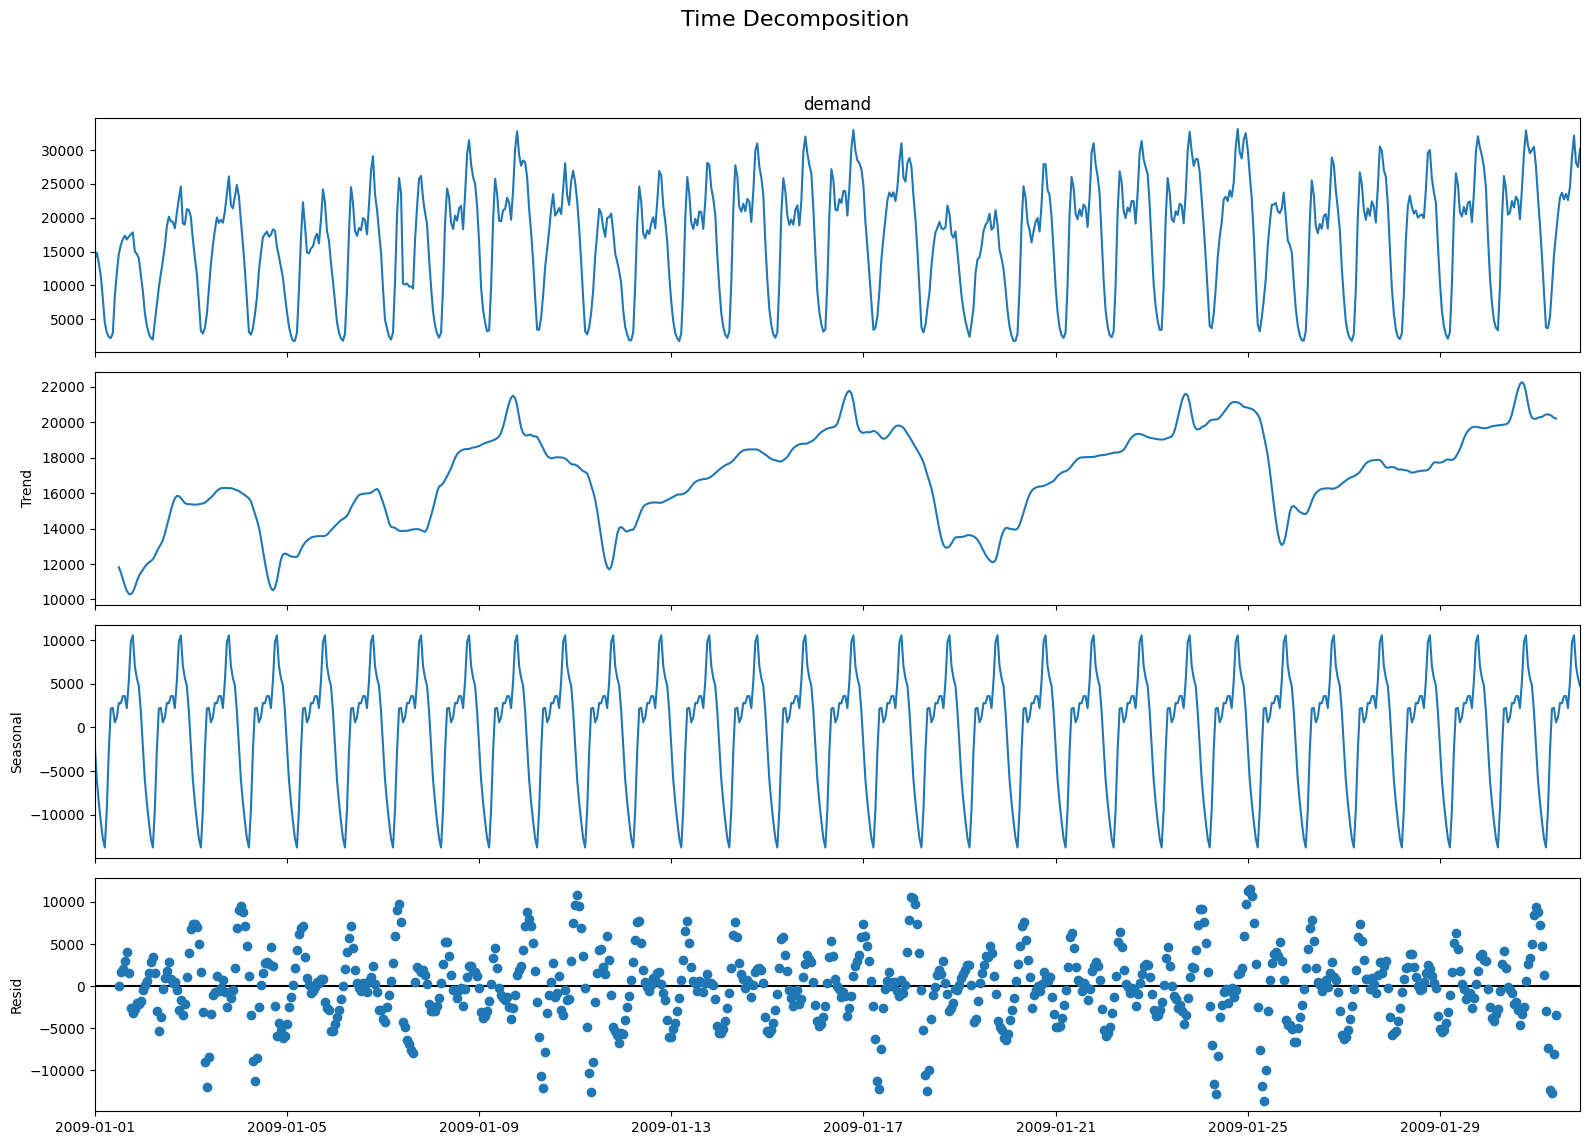

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt


# Convert 'time_bin' to datetime format
grouped_df['time_bin'] = pd.to_datetime(grouped_df['time_bin'])

# Set 'time_bin' as the DataFrame index
grouped_df.set_index('time_bin', inplace=True)

# Perform time decomposition
result = seasonal_decompose(grouped_df['demand'], model='additive', period=24)  # Assuming a daily seasonality, adjust the period if needed

# Plot the decomposition
plt.rcParams.update({'figure.figsize': (16,12)})
result.plot().suptitle('Time Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

as we can see we have an non linear trend and Saisonality
Also abit patterns can be seen for the residuals
now we wanna test for stationarity

ADF Statistic: -3.7078149877235824
p-value: 0.004004562568008773
Critical Values: {'1%': -3.439439614524914, '5%': -2.865551414233055, '10%': -2.5689061365397747}
The time series is likely stationary.


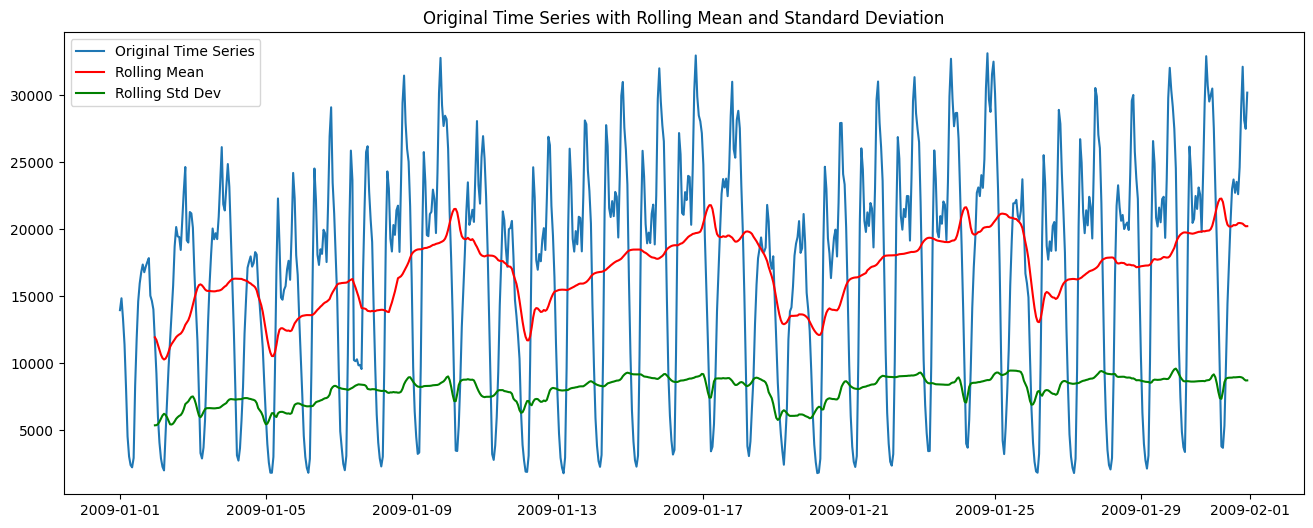

In [ ]:
from statsmodels.tsa.stattools import adfuller
# Assuming 'grouped_df' is your DataFrame with 'time_bin' as the index
time_series = grouped_df['demand']

# Perform ADF test
result_adf = adfuller(time_series)

# Display the ADF test results
print('ADF Statistic:', result_adf[0])
print('p-value:', result_adf[1])
print('Critical Values:', result_adf[4])

# Check the p-value against the significance level (e.g., 0.05) to determine stationarity
if result_adf[1] <= 0.05:
    print('The time series is likely stationary.')
else:
    print('The time series is likely non-stationary.')


from scipy.stats import probplot
# Calculate rolling statistics
rolling_mean = time_series.rolling(window=24, center=False).mean()  # Adjust the window size based on your data
rolling_std = time_series.rolling(window=24, center=False).std()

# Plot original time series, rolling mean, and rolling standard deviation
plt.figure(figsize=(16, 6))
plt.plot(time_series, label='Original Time Series')
plt.plot(rolling_mean, label='Rolling Mean', color='red')
plt.plot(rolling_std, label='Rolling Std Dev', color='green')
plt.title('Original Time Series with Rolling Mean and Standard Deviation')
plt.legend()
plt.show()


* A fixed pattern in the rolling mean, especially one that varies from 10,000 to 20,000, suggests a significant and
systematic change in the average demand over time. This pattern may indicate the presence of a trend or seasonality.

* The fact that the rolling mean does not stay constant suggests that the mean of the time series is changing over time.

* If the rolling standard deviation remains relatively constant around a value, such as 7,500, it indicates a consistent level of variability or dispersion in the data points.

--> Given these observations, it's likely that your time series is non-stationary due to the presence of a trend or seasonality. Since our afd test suggested likely stationary we should do addiotonal tests



Lets do addidtional tests for Stationary

In [ ]:
from statsmodels.tsa.stattools import kpss

# Assuming 'grouped_df' is your DataFrame with 'time_bin' as the index
time_series = grouped_df['demand']

# Perform KPSS test
result_kpss = kpss(time_series)

# Display the KPSS test results
print('KPSS Statistic:', result_kpss[0])
print('p-value:', result_kpss[1])
print('Critical Values:', result_kpss[3])

# Check the p-value against the significance level (e.g., 0.05) to determine stationarity
if result_kpss[1] <= 0.05:
    print('The time series is likely non-stationary around a deterministic trend.')
else:
    print('The time series is likely stationary around a deterministic trend.')

KPSS Statistic: 0.7030912709834388
p-value: 0.01326442991059647
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
The time series is likely non-stationary around a deterministic trend.


we can Sum Up the Demand Data as follow:

* non-stationary
* positive non-linear Trend
* contains saisonal Factor

In [ ]:
print(train_data)

                               zone  demand
time_bin                                   
2009-01-01 00:00:00   Alphabet City     121
2009-01-01 01:00:00   Alphabet City     138
2009-01-01 02:00:00   Alphabet City     124
2009-01-01 03:00:00   Alphabet City     124
2009-01-01 04:00:00   Alphabet City     100
...                             ...     ...
2009-01-31 18:00:00  Yorkville West     784
2009-01-31 19:00:00  Yorkville West     851
2009-01-31 20:00:00  Yorkville West     812
2009-01-31 21:00:00  Yorkville West     854
2009-01-31 22:00:00  Yorkville West     848

[49781 rows x 2 columns]


### B each Zone seperately

Now the same for each zone seperately

In [ ]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import STL

df = train_data.copy()

# Set 'time_bin' as the index
df.set_index('time_bin', inplace=True)

# Create a new DataFrame to store results
results_df = pd.DataFrame(columns=['Zone', 'ADF Statistic', 'P-value (ADF)', 'KPSS Statistic', 'P-value (KPSS)', 'Is Stationary', 'Seasonality'])

# Iterate over unique 'zone' values and perform tests
for zone in df['zone'].unique():
    subset = df[df['zone'] == zone]['demand']

    # ADF Test for stationarity
    adf_result = adfuller(subset, autolag='AIC')

    # KPSS Test for stationarity
    kpss_result = kpss(subset, regression='c')

    # Seasonality detection using STL
    stl = STL(subset, seasonal=13)  # Assuming a seasonal period of 13 for monthly data
    stl_result = stl.fit()
    seasonal_component = stl_result.seasonal

    # Determine seasonality based on STL results
    seasonality = 'Yes' if not seasonal_component.isna().all() else 'No'

    # Append results to the new DataFrame
    results_df = results_df.append({
        'Zone': zone,
        'ADF Statistic': adf_result[0],
        'P-value (ADF)': adf_result[1],
        'KPSS Statistic': kpss_result[0],
        'P-value (KPSS)': kpss_result[1],
        'Is Stationary': 'Stationary' if adf_result[1] < 0.05 and kpss_result[1] > 0.05 else 'Non-Stationary',
        'Seasonality': seasonality
    }, ignore_index=True)

<ipython-input-51-0924210302e6>:21: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(subset, regression='c')
<ipython-input-51-0924210302e6>:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
<ipython-input-51-0924210302e6>:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
<ipython-input-51-0924210302e6>:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
<ipython-input-51-0924210302e6>:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

or as a function:

In [ ]:
# as a function:
def analyze_stationarity_seasonality(data):
    data.set_index('time_bin', inplace=True)
    results = []

    for zone in data['zone'].unique():
        subset = data[data['zone'] == zone]['demand']
        adf_stat, adf_p = adfuller(subset, autolag='AIC')[:2]
        kpss_stat, kpss_p = kpss(subset, regression='c')[:2]
        seasonal_component = STL(subset, seasonal=13).fit().seasonal
        seasonality = 'Yes' if not seasonal_component.isna().all() else 'No'
        is_stationary = 'Stationary' if adf_p &lt; 0.05 and kpss_p &gt; 0.05 else 'Non-Stationary'

        results.append([zone, adf_stat, adf_p, kpss_stat, kpss_p, is_stationary, seasonality])

    return pd.DataFrame(results, columns=['Zone', 'ADF Statistic', 'P-value (ADF)', 'KPSS Statistic', 'P-value (KPSS)', 'Is Stationary', 'Seasonality'])


results for stationary based based on adf and KPSS statistics

In [ ]:
from IPython.display import display, HTML

# Convert the results DataFrame to HTML
html_table = results_df.to_html(index=False)

# Display the HTML table without scrollbar
display(HTML(html_table))

Zone,ADF Statistic,P-value (ADF),KPSS Statistic,P-value (KPSS),Is Stationary,Seasonality
Alphabet City,-3.123408,2.486870e-02,0.246364,0.100000,Stationary,Yes
Battery Park,-5.190663,9.186305e-06,0.470272,0.048362,Non-Stationary,Yes
Battery Park City,-5.232699,7.536573e-06,0.543912,0.031777,Non-Stationary,Yes
Bloomingdale,-3.856077,2.382956e-03,0.593627,0.023216,Non-Stationary,Yes
Central Harlem,-2.909378,4.426832e-02,0.374061,0.088336,Stationary,Yes
Central Harlem North,-5.132426,1.206013e-05,0.167972,0.100000,Stationary,Yes
Central Park,-5.094964,1.434958e-05,0.231915,0.100000,Stationary,Yes
Chinatown,-3.874641,2.229607e-03,0.639167,0.019076,Non-Stationary,Yes
Clinton East,-4.378799,3.235540e-04,0.567719,0.026415,Non-Stationary,Yes
Clinton West,-5.213330,8.257555e-06,0.925120,0.010000,Non-Stationary,Yes


Even we could see in the All zones data that the Trend ist mostly non-linear lets add this for the sake of completeness

- remove seasonality
- calcluate R^2 for linear and square model. If quare Models fit better the the Demand -> non linear Trend

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt

# Neue Spalte für den bereinigten Trend hinzufügen
results_df['Trend Type'] = ''

# Iterate over unique 'zone' values and perform tests
for zone in df['zone'].unique():
    subset = df[df['zone'] == zone]['demand']

    # Saisonalität entfernen
    stl = STL(subset, seasonal= 7)  # 7 days
    stl_result = stl.fit()
    trend_component = stl_result.trend

    # Lineare Regression für den bereinigten linearen Trend
    X_linear = np.arange(len(trend_component)).reshape(-1, 1)
    model_linear = LinearRegression().fit(X_linear, trend_component.values.reshape(-1, 1))
    trend_linear = model_linear.predict(X_linear)

    # Quadratische Regression für den bereinigten nicht-linearen Trend
    X_poly = PolynomialFeatures(degree=2).fit_transform(X_linear)
    model_poly = LinearRegression().fit(X_poly, trend_component.values.reshape(-1, 1))
    trend_poly = model_poly.predict(X_poly)

    # Aktualisieren Sie den Trendtyp in der results_df
    if model_linear.score(X_linear, trend_component.values.reshape(-1, 1)) > model_poly.score(X_poly, trend_component.values.reshape(-1, 1)):
        results_df.loc[results_df['Zone'] == zone, 'Trend Type'] = 'Linear'
    else:
        results_df.loc[results_df['Zone'] == zone, 'Trend Type'] = 'Non-Linear'

Full Table for each zone

In [ ]:
# Convert the results DataFrame to HTML
html_table = results_df.to_html(index=False)

# Display the HTML table without scrollbar
display(HTML(html_table))

zone_informations = results_df

Zone,ADF Statistic,P-value (ADF),KPSS Statistic,P-value (KPSS),Is Stationary,Seasonality,Trend Type
Alphabet City,-3.123408,2.486870e-02,0.246364,0.100000,Stationary,Yes,Non-Linear
Battery Park,-5.190663,9.186305e-06,0.470272,0.048362,Non-Stationary,Yes,Non-Linear
Battery Park City,-5.232699,7.536573e-06,0.543912,0.031777,Non-Stationary,Yes,Non-Linear
Bloomingdale,-3.856077,2.382956e-03,0.593627,0.023216,Non-Stationary,Yes,Non-Linear
Central Harlem,-2.909378,4.426832e-02,0.374061,0.088336,Stationary,Yes,Non-Linear
Central Harlem North,-5.132426,1.206013e-05,0.167972,0.100000,Stationary,Yes,Non-Linear
Central Park,-5.094964,1.434958e-05,0.231915,0.100000,Stationary,Yes,Non-Linear
Chinatown,-3.874641,2.229607e-03,0.639167,0.019076,Non-Stationary,Yes,Non-Linear
Clinton East,-4.378799,3.235540e-04,0.567719,0.026415,Non-Stationary,Yes,Non-Linear
Clinton West,-5.213330,8.257555e-06,0.925120,0.010000,Non-Stationary,Yes,Non-Linear


Results of EDA:


*   *We need an Foremodel which can handle Non-Stationary, Seasonality and Non-Linear Trends*



# 3.Building Forecast

Load Data from Drive

*   train Data = Januar 2009  - 1 Hour Time binned
*   test Data  = Februar 2009 - 1 Hour Time binned

In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

file_path_train = '/content/drive/My Drive/Projektseminar/data_train_1Hour.parquet'
train_data = pd.read_parquet(file_path_train)

file_path_test  = '/content/drive/My Drive/Projektseminar/data_test_200902_1Hour.parquet'
test_data = pd.read_parquet(file_path_test)

#display(train_data)
#display(test_data)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Since all demand varies across zones we should take it into account when we evaluate our loss function later. So first just calculate the demand share of each zone


In [ ]:
def calculate_demandshares_all_zones(data):
    df = data
    total_demand = df['demand'].sum()

    # Group by 'zone' and calculate the sum of 'demand' for each zone
    result = df.groupby('zone')['demand'].sum().reset_index()

    # Calculate the percentage of 'demand' for each zone
    result['percentage'] = (result['demand'] / total_demand) * 100
    result = result.sort_values(by='percentage', ascending=False)

    # Display the result
    return result

demandshares = calculate_demandshares_all_zones(train_data)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Now, when you print or display the DataFrame, it will show all rows without truncation
print(demandshares)

# Reset the display options to default if needed
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')


                                             zone  demand  percentage
57                          Upper East Side South  534176    4.121937
51                      Times Sq/Theatre District  527515    4.070538
38                                 Midtown Center  521298    4.022565
13                                   East Village  510263    3.937414
56                          Upper East Side North  499016    3.850627
43                                    Murray Hill  468451    3.614774
39                                   Midtown East  467169    3.604882
55                                       Union Sq  456317    3.521143
30                            Lincoln Square East  426182    3.288608
8                                    Clinton East  418530    3.229562
19                                       Gramercy  401146    3.095419
44                   Penn Station/Madison Sq West  399355    3.081599
29                                Lenox Hill West  378532    2.920920
40                  

In [ ]:
print("train Data")
display(train_data)
print("test Data")
display(test_data)

train Data


,zone,time_bin,demand
0,Alphabet City,2009-01-01 00:00:00,121
1,Alphabet City,2009-01-01 01:00:00,138
2,Alphabet City,2009-01-01 02:00:00,124
3,Alphabet City,2009-01-01 03:00:00,124
4,Alphabet City,2009-01-01 04:00:00,100
...,...,...,...
49776,Yorkville West,2009-01-31 18:00:00,784
49777,Yorkville West,2009-01-31 19:00:00,851
49778,Yorkville West,2009-01-31 20:00:00,812
49779,Yorkville West,2009-01-31 21:00:00,854


test Data


,zone,time_bin,demand
0,Alphabet City,2009-02-01 00:00:00,348
1,Alphabet City,2009-02-01 01:00:00,375
2,Alphabet City,2009-02-01 02:00:00,432
3,Alphabet City,2009-02-01 03:00:00,291
4,Alphabet City,2009-02-01 04:00:00,212
...,...,...,...
44952,Yorkville West,2009-02-28 18:00:00,734
44953,Yorkville West,2009-02-28 19:00:00,787
44954,Yorkville West,2009-02-28 20:00:00,830
44955,Yorkville West,2009-02-28 21:00:00,815


## 3.1 Prophet

For now we will start with the Prophet Forecast model and look if we get suitable results.
Fixed set variable names in Prophet:


*   ds = datestamp
*   yhat = contains the predicted values of the time series at each corresponding 'ds' (datestamp) in the future

own variables:



*   forecast_default: Forecast without Hyperparameter tuning
*   forecast_best:    forecast with Hyperparameter tuning






**Note:**


---


First, we want to find the ideal parameters for "initial", "period" and "horizon" using cross validation. This is done on the basis of all zones. These are then fixed for all further steps, as a calculation for each zone individually would be too time-consuming.

The hyperparameters are then tuned  using cross validation, but now once for the whole of Manhattan and once for each zone.

The recommendations for cross validation and Hyperparameter settings in the Prophet documentation were always followed by the official recommentation in the documentation: https://facebook.github.io/prophet/docs/diagnostics.html

Load and install neccessary Packages

In [ ]:
!pip install prophet
import warnings
from prophet import Prophet
import logging
import cmdstanpy
from sklearn.metrics import mean_squared_error, mean_absolute_error
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric
import itertools
import logging

switch off warnings in our output window

In [ ]:
warnings.filterwarnings("ignore", category=UserWarning, module="cmdstanpy")
warnings.filterwarnings("ignore", category=UserWarning, module="prophet")
logging.basicConfig(level=logging.WARNING)
logging.getLogger("prophet").setLevel(logging.WARNING)
logging.getLogger("prophet.forecaster").setLevel(logging.WARNING)
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)


quick forecast test on full data to see how the forecast works

                      ds          yhat    yhat_lower    yhat_upper
0    2009-01-01 00:00:00  11436.459317   5801.086845  17512.691099
1    2009-01-01 01:00:00   8713.723882   2873.790365  14662.700611
2    2009-01-01 02:00:00   5024.662408   -971.779597  11160.161618
3    2009-01-01 03:00:00   1232.538809  -4129.432863   7517.056676
4    2009-01-01 04:00:00   -715.148548  -6482.634312   4977.127196
...                  ...           ...           ...           ...
1410 2009-02-28 18:00:00  31289.730282  24466.668998  37598.276051
1411 2009-02-28 19:00:00  32796.483288  26162.931144  39455.700792
1412 2009-02-28 20:00:00  32195.350066  25825.639099  38710.126341
1413 2009-02-28 21:00:00  29555.492631  22625.707118  36036.887984
1414 2009-02-28 22:00:00  26123.741100  20003.607530  32537.601964

[1415 rows x 4 columns]


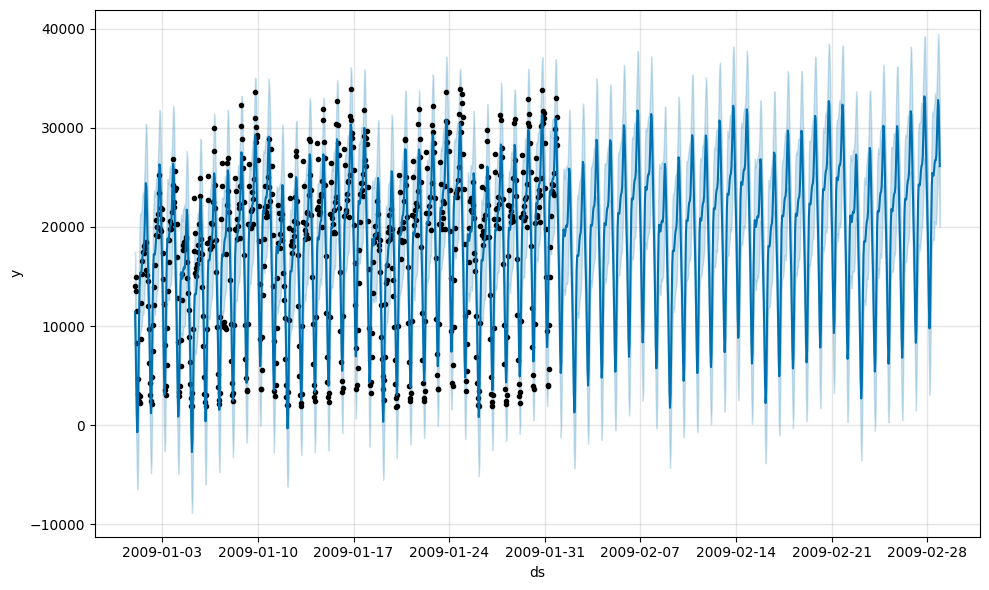

In [ ]:
df = train_data.copy().groupby('time_bin')['demand'].sum().reset_index().rename(columns={'time_bin': 'ds', 'demand': 'y'})

model = Prophet()
model.fit(df)

future = model.make_future_dataframe(periods=28*24,  freq='H', include_history=True)
forecast = model.predict(future)
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

fig1 = model.plot(forecast)

### 3.1 Forecast Manhattan all zones


In [ ]:
df = train_data.copy().groupby('time_bin')['demand'].sum().reset_index().rename(columns={'time_bin': 'ds', 'demand': 'y'})

model = Prophet().fit(df)

all_cv_params = [
    {"initial": "7 days", "period": f" {i} days", "horizon": "21 days"} for i in [0.5, 1, 2, 3, 7]
] + [
    {"initial": "14 days", "period": f" {i} days", "horizon": "14 days"} for i in [0.5, 1, 2, 3, 7]
] + [
    {"initial": "21 days", "period": f" {i} days", "horizon": "7 days"} for i in [0.5, 1, 2, 3, 7]
]

rmses_cv = []
for cv_params in all_cv_params:
    df_cv = cross_validation(model, initial=cv_params['initial'], period=cv_params['period'], horizon=cv_params['horizon'])
    df_p = performance_metrics(df_cv)
    rmses_cv.append(df_p['mape'].values[0])

# Find the best cross-validation parameters
cv_results = pd.DataFrame(all_cv_params)
cv_results['mape'] = rmses_cv
best_cv_params = cv_results.loc[cv_results['mape'].idxmin()]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

or as a function:

In [ ]:
def find_best_cv_params(train_data):
    # Prepare the data
    df = train_data.copy().groupby('time_bin')['demand'].sum().reset_index().rename(columns={'time_bin': 'ds', 'demand': 'y'})

    # Fit Prophet model
    model = Prophet().fit(df)

    # Define all cross-validation parameter combinations
    all_cv_params = [
        {"initial": "7 days", "period": f" {i} days", "horizon": "21 days"} for i in [0.5, 1, 2, 3, 7]
    ] + [
        {"initial": "14 days", "period": f" {i} days", "horizon": "14 days"} for i in [0.5, 1, 2, 3, 7]
    ] + [
        {"initial": "21 days", "period": f" {i} days", "horizon": "7 days"} for i in [0.5, 1, 2, 3, 7]
    ]

    # Perform cross-validation for each parameter combination and calculate MAPE
    rmses_cv = []
    for cv_params in all_cv_params:
        df_cv = cross_validation(model, initial=cv_params['initial'], period=cv_params['period'], horizon=cv_params['horizon'])
        df_p = performance_metrics(df_cv)
        rmses_cv.append(df_p['mape'].values[0])

    # Create DataFrame to store results
    cv_results = pd.DataFrame(all_cv_params)
    cv_results['mape'] = rmses_cv

    # Find the best cross-validation parameters
    best_cv_params = cv_results.loc[cv_results['mape'].idxmin()]

    return best_cv_params

In [ ]:
# Display the results
display(cv_results)
print(f'Best Cross-Validation Parameters: {best_cv_params}')

,initial,period,horizon,mape
0,7 days,0.5 days,21 days,0.554142
1,7 days,1 days,21 days,0.607587
2,7 days,2 days,21 days,0.519675
3,7 days,3 days,21 days,0.571013
4,7 days,7 days,21 days,0.571013
5,14 days,0.5 days,14 days,0.457973
6,14 days,1 days,14 days,0.574655
7,14 days,2 days,14 days,0.520331
8,14 days,3 days,14 days,0.514205
9,14 days,7 days,14 days,0.514205


Best Cross-Validation Parameters: initial      21 days
period      0.5 days
horizon       7 days
mape        0.326424
Name: 10, dtype: object


Best Cross-Validation Parameters:

initial      21 days

*   initial : 21 days
*   perios  : 5 days
*   horizon : 7 days
*   mape: 33%



define Functions and Constants

In [ ]:
# Constants
INITIAL_PERIOD = "21 days"
PERIOD = "0.5 days"
HORIZON = "7 days"

param_grid = {
    "changepoint_prior_scale": [0.001, 0.01, 0.1, 0.5],
    "seasonality_prior_scale": [0.01,  0.1, 1.0, 10.0],
    "seasonality_mode": ['additive', 'multiplicative'],
    # "holidays_prior_scale":    [0.01,  0.1, 1.0, 10.0],
}

def make_forecast(model, df):
    """Make a forecast using the given model and DataFrame."""
    future = model.make_future_dataframe(periods=28 * 24, freq="h", include_history=False)
    forecast = model.predict(future)
    return forecast

def tune_prophet_parameters(df, param_grid):
    """Tune Prophet parameters and return the best parameters."""
    errors = []

    all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

    for params in all_params:
        model = Prophet(**params).fit(df)
        df_cv = cross_validation(model, initial=INITIAL_PERIOD, period=PERIOD, horizon=HORIZON)
        df_p = performance_metrics(df_cv)

        # Check if 'mape' is present, otherwise, use MSE as an alternative metric
        if 'mape' in df_p.columns:
            errors.append(df_p['mape'].values[0])
        else:
            # Use MSE as an alternative metric
            errors.append(df_p['mse'].values[0])

    tuning_results = pd.DataFrame(all_params)
    tuning_results['error'] = errors
    best_params = tuning_results.loc[tuning_results['error'].idxmin()].drop('error')
    return best_params

def calculate_mape(table, forecast_column, actual_column):
    """Calculate Mean Absolute Percentage Error (MAPE)."""
    mape = np.mean(np.abs((table[actual_column] - table[forecast_column]) / table[actual_column])) * 100
    return mape




Results for all zones forecast

In [ ]:
warnings.filterwarnings("ignore", category=UserWarning, module="cmdstanpy")
warnings.filterwarnings("ignore", category=UserWarning, module="prophet")
logging.basicConfig(level=logging.WARNING)
logging.getLogger("prophet").setLevel(logging.CRITICAL)
logging.getLogger("prophet.forecaster").setLevel(logging.CRITICAL)
logging.getLogger('cmdstanpy').setLevel(logging.CRITICAL)


df = train_data.copy().groupby('time_bin')['demand'].sum().reset_index().rename(columns={'time_bin': 'ds', 'demand': 'y'})

# Tune parameters and get the best ones
best_params = tune_prophet_parameters(df, param_grid)
best_model = Prophet(**best_params).fit(df)

# Make forecasts with the best model and default model
forecast_best = make_forecast(best_model, df)
default_model = Prophet().fit(df)
forecast_default = make_forecast(default_model, df)

# Create a table with both forecasts
table = pd.DataFrame({
    'ds': forecast_best['ds'],
    'forecast_best': round(forecast_best['yhat']).astype(int),
    'forecast_default': round(forecast_default['yhat']).astype(int)
})

# Merge with filtered_test_data
filtered_test_data = test_data.copy().groupby('time_bin')['demand'].sum().reset_index().rename(columns={'time_bin': 'ds'})
table = pd.merge(table, filtered_test_data[['ds', 'demand']], on='ds', how='left')
table.rename(columns={'demand': 'test_demand'}, inplace=True)

# Calculate and print MAPE for both forecasts
mape_best = calculate_mape(table, 'forecast_best', 'test_demand')
mape_default = calculate_mape(table, 'forecast_default', 'test_demand')

# Display the final table
display(table)
print(f'MAPE for forecast_best: {mape_best:.2f}%')
print(f'MAPE for forecast_default: {mape_default:.2f}%')


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

,ds,forecast_best,forecast_default,test_demand
0,2009-01-31 23:00:00,21222,21206,NaN
1,2009-02-01 00:00:00,18371,18628,29607.0
2,2009-02-01 01:00:00,15049,15618,26464.0
3,2009-02-01 02:00:00,10669,11631,22652.0
4,2009-02-01 03:00:00,6184,7532,16992.0
...,...,...,...,...
667,2009-02-28 18:00:00,32591,31290,29846.0
668,2009-02-28 19:00:00,34420,32796,32381.0
669,2009-02-28 20:00:00,33758,32195,28144.0
670,2009-02-28 21:00:00,30663,29555,27522.0


MAPE for forecast_best: 36.47%
MAPE for forecast_default: 43.22%




*   Mape without hp tuning: 36%
*   Mape with hp tuning   : 43%

But since this in on the full data tuning should get much better if we do it on each zone seperately.

Also remember we had hourly time binned data, so our Mape is also hourly based. If we sum up the data in longer time intervalls our mape should be much better. So lets calculate Mape for different time intervalls.

-> Lets assume the Forecast gets more accurate the bigger our time corridor isfor our loss function, since its difficult to predict the exact value on each hour that for a day etc.



Collected MAPE Values:


<ipython-input-36-8e925975d6ec>:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  table_interval = filtered_table.resample(interval).sum()


,Interval,MAPE_best,MAPE_default
0,1H,36.469946,43.222387
1,3H,32.524271,37.425631
2,6H,27.854336,32.550632
3,12H,9.199230,10.944263
4,24H,7.673787,8.991471
5,3D,7.372757,8.894697
6,7D,6.697683,8.242129


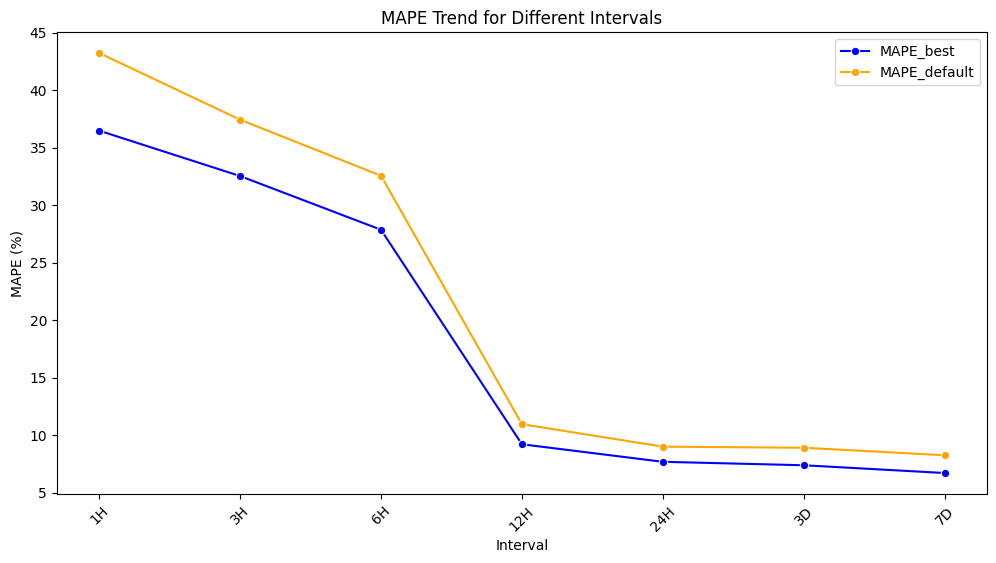

In [ ]:
#assume functions: tune_prophet_parameters, make_forecast und calculate_mape

# Liste der Zeitintervalle, für die Sie den MAPE berechnen möchten
time_intervals = ['1H', '3H', '6H', '12H', '24H', '3D', '7D']


table.set_index('ds', inplace=True)

# Liste zum Speichern der berechneten MAPE-Werte für jedes Intervall
mape_list = []

# Filtern Sie das DataFrame nach Zeilen, in denen 'test_demand' weder Null noch NaN ist
filtered_table = table[table['test_demand'].notna()]

# Durchlaufen Sie die Zeitintervalle und erstellen Sie die Tabelle für jedes Intervall
for interval in time_intervals:
    try:
        # Gruppieren Sie die Daten nach dem aktuellen Zeitintervall
        table_interval = filtered_table.resample(interval).sum()
        # Prüfen Sie, ob das gefilterte DataFrame nicht leer ist, bevor Sie den MAPE berechnen
        if not table_interval.empty:
            # Calculate MAPE for both forecasts for the current interval
            mape_best_interval = calculate_mape(table_interval, 'forecast_best', 'test_demand')
            mape_default_interval = calculate_mape(table_interval, 'forecast_default', 'test_demand')

            # Speichern Sie die berechneten MAPE-Werte für jedes Intervall
            mape_list.append({
                'Interval': interval,
                'MAPE_best': mape_best_interval,
                'MAPE_default': mape_default_interval
            })

        else:
            print(f'Keine gültigen MAPE-Werte für {interval} aufgrund von Nullwerten in test_demand.')

    except KeyError as e:
        print(f'Fehler beim Versuch, das Intervall {interval} zu erstellen. Möglicherweise fehlt die Spalte "ds".')
        print(f'Fehlerdetails: {e}')

# Erstellen Sie eine DataFrame für die gesammelten MAPE-Werte
mape_df = pd.DataFrame(mape_list)

# Überprüfen Sie, ob beide MAPE-Listen nicht leer sind, bevor Sie den Durchschnitt berechnen
if not mape_df.empty:
    # Durchschnittlicher MAPE über alle Intervalle berechnen
    mean_mape_best = mape_df['MAPE_best'].mean()
    mean_mape_default = mape_df['MAPE_default'].mean()


    # Ausgabe der gesammelten MAPE-Werte
    print('\nCollected MAPE Values:')
    display(mape_df)
else:
    print('Keine gültigen MAPE-Werte aufgrund von Nullwerten in test_demand.')
# Plotting
plt.figure(figsize=(12, 6))

# Linienplot für MAPE_best
sns.lineplot(x=mape_df['Interval'], y=mape_df['MAPE_best'], marker='o', label='MAPE_best', color='blue')

# Linienplot für MAPE_default
sns.lineplot(x=mape_df['Interval'], y=mape_df['MAPE_default'], marker='o', label='MAPE_default', color='orange')

plt.title('MAPE Trend for Different Intervals')
plt.xlabel('Interval')
plt.ylabel('MAPE (%)')
plt.xticks(rotation=45)
plt.legend()
plt.show()

table.reset_index(inplace=True)

As we can see the longer the time Intervall the better our Forecast. To work with 12h Forecast looks like the best solution.

Visualization of Forecast and Test Data

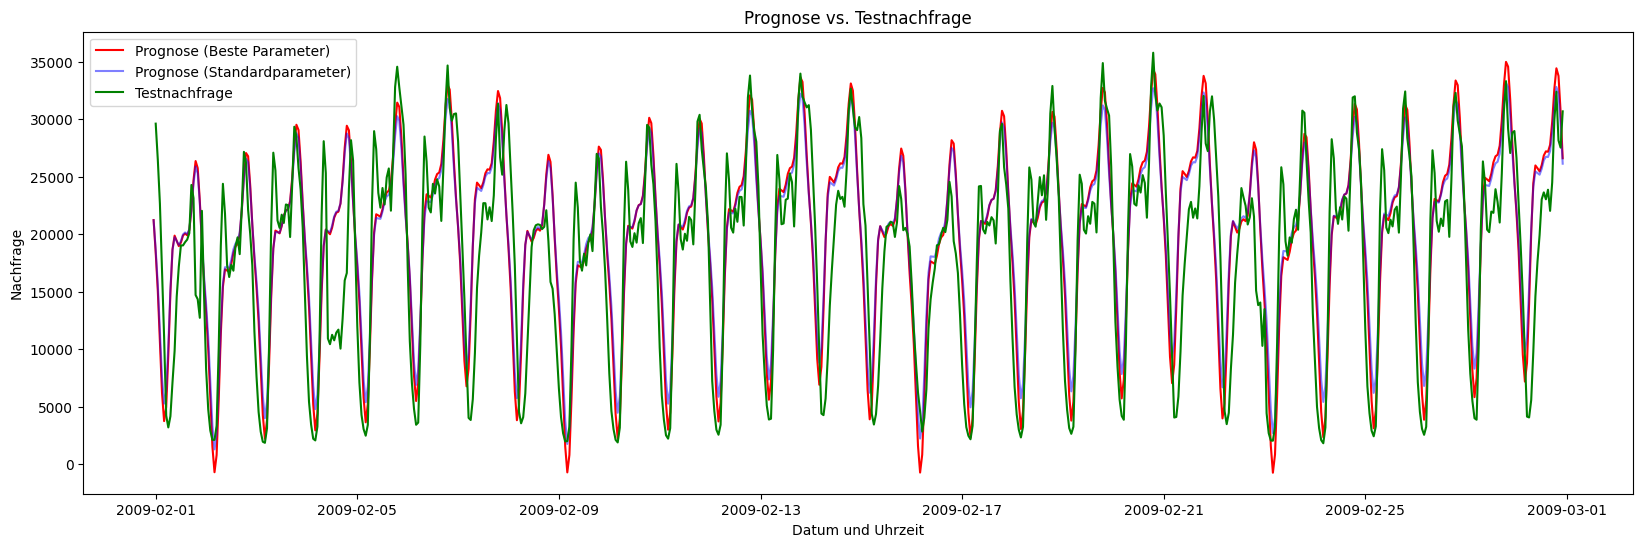

In [ ]:
table.reset_index(inplace=True)

plt.figure(figsize=(20, 6))
plt.plot(table['ds'], table['forecast_best'], label='Prognose (Beste Parameter)',  color='red')
plt.plot(table['ds'], table['forecast_default'], label='Prognose (Standardparameter)', color= "blue", alpha= 0.5)
plt.plot(table['ds'], table['test_demand'], label='Testnachfrage', color = "green")
plt.xlabel('Datum und Uhrzeit')
plt.ylabel('Nachfrage')
plt.title('Prognose vs. Testnachfrage')
plt.legend()
plt.show()

Find the timestamp with the biggest Mape Value

Timestamp with the highest MAPE:
ds                            2009-02-08 07:00:00
index               1970-01-01 00:00:00.000000176
forecast_best                               15193
forecast_default                            15673
test_demand                                4089.0
mape_best                              271.557838
Name: 176, dtype: object


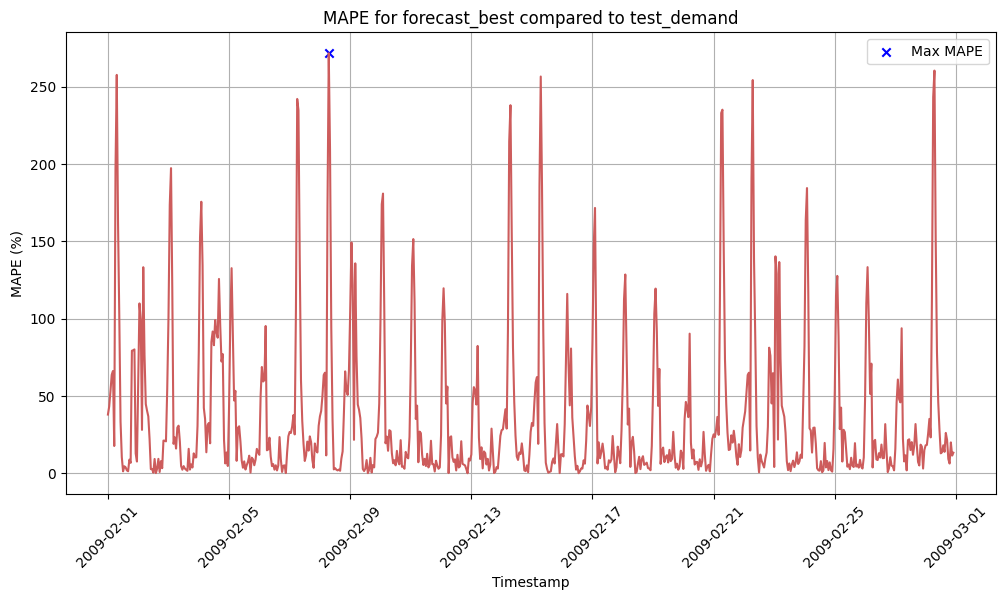

In [ ]:
# Calculate MAPE
table['mape_best'] = np.abs((table['test_demand'] - table['forecast_best']) / table['test_demand']) * 100

# Find the index with the maximum MAPE
max_mape_index = table['mape_best'].idxmax()

# Display the row with the maximum MAPE
print("Timestamp with the highest MAPE:")
print(table.loc[max_mape_index])

# Plot the MAPE for each timestamp
plt.figure(figsize=(12, 6))
plt.plot(table['ds'], table['mape_best'], linestyle='-', color='indianred')
plt.scatter(table['ds'][max_mape_index], table['mape_best'][max_mape_index], color='blue', marker='x', label='Max MAPE')
plt.xlabel('Timestamp')
plt.ylabel('MAPE (%)')
plt.title('MAPE for forecast_best compared to test_demand')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

Now filter our Visualization to the Date with the Mape Max Value

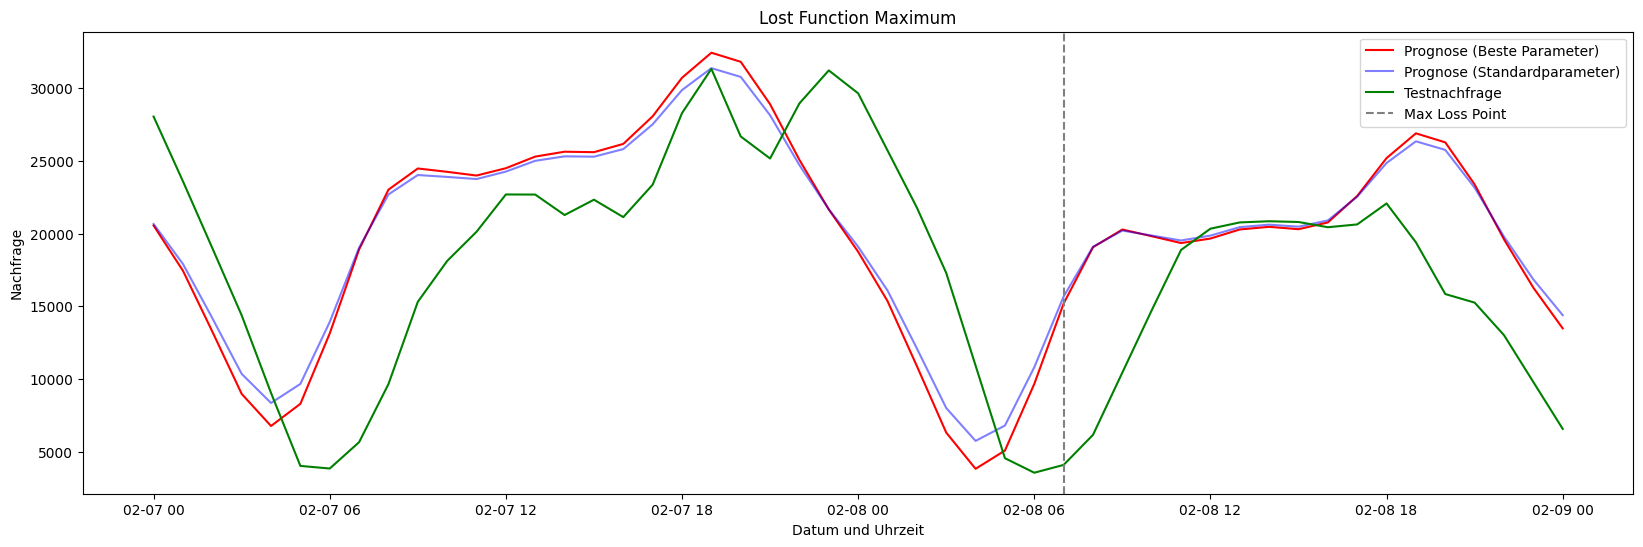

In [ ]:
# Filter data for the specified date range
start_date = '2009-02-07'
end_date = '2009-02-09'
filtered_table = table[(table['ds'] >= start_date) & (table['ds'] <= end_date)]

# Convert the vertical line date to pandas datetime
vertical_line_date = pd.to_datetime('2009-02-08 07:00:00')

# Plot for the specified date range


plt.figure(figsize=(20, 6))
plt.plot(filtered_table['ds'], filtered_table['forecast_best'], label='Prognose (Beste Parameter)', color='red')
plt.plot(filtered_table['ds'], filtered_table['forecast_default'], label='Prognose (Standardparameter)', color="blue", alpha=0.5)
plt.plot(filtered_table['ds'], filtered_table['test_demand'], label='Testnachfrage', color="green")
plt.axvline(x=vertical_line_date, color='gray', linestyle='--', label='Max Loss Point')
plt.xlabel('Datum und Uhrzeit')
plt.ylabel('Nachfrage')
plt.title('Lost Function Maximum')
plt.legend()
plt.show()

As we can see our Forecast isnt to bad. Its more like we reach the seasonal Peaks to late or to early.

If we sum up our Forecast to at least 12h Forecasts this should fix the problem.


### 3.2 Forecast each zone

Now we make the Forecast for each Zone

In [ ]:
warnings.filterwarnings("ignore", category=UserWarning, module="cmdstanpy")
warnings.filterwarnings("ignore", category=UserWarning, module="prophet")
logging.basicConfig(level=logging.WARNING)
logging.getLogger("prophet").setLevel(logging.CRITICAL)
logging.getLogger("prophet.forecaster").setLevel(logging.CRITICAL)
logging.getLogger('cmdstanpy').setLevel(logging.CRITICAL)

def generate_combined_forecast_table(train_data, test_data, param_grid):
    unique_zones = train_data['zone'].unique()
    combined_forecast_table = pd.DataFrame()

    for zone in tqdm(unique_zones, desc='Processing zones'):
        zone_data = train_data[train_data['zone'] == zone].copy().groupby('time_bin')['demand'].sum().reset_index().rename(columns={'time_bin': 'ds', 'demand': 'y'})

        best_params = tune_prophet_parameters(zone_data, param_grid)
        best_model = Prophet(**best_params).fit(zone_data)
        forecast_best = make_forecast(best_model, zone_data)

        default_model = Prophet().fit(zone_data)
        forecast_default = make_forecast(default_model, zone_data)

        table_zone = pd.DataFrame({
            'ds': forecast_best['ds'],
            'forecast_best': round(forecast_best['yhat']).astype(int),
            'forecast_default': round(forecast_default['yhat']).astype(int),
            'Zone': zone
        })

        filtered_test_data_zone = test_data[test_data['zone'] == zone].copy().groupby('time_bin')['demand'].sum().reset_index().rename(columns={'time_bin': 'ds', 'demand': 'test_demand'})
        table_zone = pd.merge(table_zone, filtered_test_data_zone[['ds', 'test_demand']], on='ds', how='left')
        print(table_zone)
        combined_forecast_table = pd.concat([combined_forecast_table, table_zone], ignore_index=True)

    return combined_forecast_table

# Usage
combined_forecast_table = generate_combined_forecast_table(train_data, test_data, param_grid)

In [ ]:
display(combined_forecast_table)
#safe data
combined_forecast_table.to_parquet('/content/drive/My Drive/Projektseminar/PROPHET_Forecast_allZones.parquet', index=False)

,ds,forecast_best,forecast_default,Zone,test_demand
0,2009-01-31 23:00:00,158,181,Alphabet City,NaN
1,2009-02-01 00:00:00,166,192,Alphabet City,348.0
2,2009-02-01 01:00:00,167,194,Alphabet City,375.0
3,2009-02-01 02:00:00,153,174,Alphabet City,432.0
4,2009-02-01 03:00:00,125,138,Alphabet City,291.0
...,...,...,...,...,...
45019,2009-02-28 18:00:00,704,703,Yorkville West,734.0
45020,2009-02-28 19:00:00,737,736,Yorkville West,787.0
45021,2009-02-28 20:00:00,735,734,Yorkville West,830.0
45022,2009-02-28 21:00:00,704,703,Yorkville West,815.0


load data

In [ ]:
ProphetForecast_path_train = '/content/drive/My Drive/Projektseminar/PROPHET_Forecast_allZones.parquet'
Forecast_data = pd.read_parquet(ProphetForecast_path_train)
display(Forecast_data)



,ds,forecast_best,forecast_default,Zone,test_demand
0,2009-01-31 23:00:00,158,181,Alphabet City,NaN
1,2009-02-01 00:00:00,166,192,Alphabet City,348.0
2,2009-02-01 01:00:00,167,194,Alphabet City,375.0
3,2009-02-01 02:00:00,153,174,Alphabet City,432.0
4,2009-02-01 03:00:00,125,138,Alphabet City,291.0
...,...,...,...,...,...
45019,2009-02-28 18:00:00,704,703,Yorkville West,734.0
45020,2009-02-28 19:00:00,737,736,Yorkville West,787.0
45021,2009-02-28 20:00:00,735,734,Yorkville West,830.0
45022,2009-02-28 21:00:00,704,703,Yorkville West,815.0


In [ ]:
df = Forecast_data
# Konvertiere die Spalte 'ds' in ein datetime-Objekt
df['ds'] = pd.to_datetime(df['ds'])

# Filtere die Daten ab dem 1. Februar 2009 um 00:00 Uhr
df = df[df['ds'] >= '2009-02-01 00:00:00']

# Runde die Zeitstempel auf das nächste 12-Stunden-Intervall
df['ds'] = df['ds'].dt.round('12H')

# Gruppiere die Daten nach 'Zone' und 'ds' und berechne den Durchschnitt der anderen Spalten
df = df.groupby(['Zone', pd.Grouper(key='ds', freq='12H')]).mean().reset_index()

# Entferne die Spalten 'forecast_default' und 'test_demand'
df = df.drop(columns=['forecast_default', 'test_demand'])

# Ausgabe des DataFrames
display(df)

<ipython-input-5-165999419bc1>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ds'] = df['ds'].dt.round('12H')


,Zone,ds,forecast_best
0,Alphabet City,2009-02-01 00:00:00,126.714286
1,Alphabet City,2009-02-01 12:00:00,96.181818
2,Alphabet City,2009-02-02 00:00:00,87.769231
3,Alphabet City,2009-02-02 12:00:00,66.363636
4,Alphabet City,2009-02-03 00:00:00,82.846154
...,...,...,...
3814,Yorkville West,2009-02-27 00:00:00,376.307692
3815,Yorkville West,2009-02-27 12:00:00,472.000000
3816,Yorkville West,2009-02-28 00:00:00,482.846154
3817,Yorkville West,2009-02-28 12:00:00,592.636364


In [ ]:
df.to_csv('/content/drive/My Drive/Projektseminar/PROPHET_Forecast_allZones.csv', index=False)

Calculate Mape for each zone and all time intervalls

In [ ]:

table = Forecast_data

table = table[table["test_demand"].notna()]
all_zone_mape_list = []
time_intervals = ['1H', '3H', '6H', '12H', '24H', '3D', '7D']

grouped_table = table.groupby('Zone')

for zone, zone_data in grouped_table:
    zone_data.set_index('ds', inplace=True)

    if 'test_demand' in zone_data.columns:
        filtered_zone_data = zone_data[zone_data['test_demand'].notna()]
        zone_mape_list = []

        for interval in time_intervals:
            zone_table_interval = filtered_zone_data.resample(interval).sum()

            if not zone_table_interval.empty:
                mape_best_interval = calculate_mape(zone_table_interval, 'forecast_best', 'test_demand')
                mape_default_interval = calculate_mape(zone_table_interval, 'forecast_default', 'test_demand')

                zone_mape_list.append({
                    'Zone': zone,
                    'Interval': interval,
                    'MAPE_best': mape_best_interval,
                    'MAPE_default': mape_default_interval
                })
            else:
                print(f'Keine gültigen MAPE-Werte für {interval} in Zone {zone} aufgrund von Nullwerten in test_demand.')

        all_zone_mape_list.extend(zone_mape_list)

    else:
        print(f'Die Spalte "test_demand" fehlt in Zone {zone}.')

filtered_all_zone_mape_df = all_zone_mape_list
display(filtered_all_zone_mape_df)

In [ ]:
result_df = pd.DataFrame(filtered_all_zone_mape_df)

# Zeigen Sie das DataFrame an
display(result_df)

,Zone,Interval,MAPE_best,MAPE_default
0,Alphabet City,1H,58.589172,59.099602
1,Alphabet City,3H,50.088312,50.857001
2,Alphabet City,6H,46.634287,47.929331
3,Alphabet City,12H,17.785565,18.435827
4,Alphabet City,24H,16.855902,17.828298
...,...,...,...,...
464,Yorkville West,6H,33.668105,34.704725
465,Yorkville West,12H,12.682220,12.752585
466,Yorkville West,24H,8.407120,8.965865
467,Yorkville West,3D,7.598449,8.367541


### 3.3 Results

Mape values for 12h binning lost function

In [ ]:
# Forecast values
display(Forecast_data)

# Mape over all zones
prophet_evaluation = result_df
result_df = result_df.replace([np.inf, -np.inf], np.nan).dropna(subset=['MAPE_best', 'MAPE_default'])
prophet_evaluation = prophet_evaluation[prophet_evaluation['Interval'] == '12H']

# Anzeige der Ergebnisse
display(prophet_evaluation)


,ds,forecast_best,forecast_default,Zone,test_demand
0,2009-01-31 23:00:00,158,181,Alphabet City,NaN
1,2009-02-01 00:00:00,166,192,Alphabet City,348.0
2,2009-02-01 01:00:00,167,194,Alphabet City,375.0
3,2009-02-01 02:00:00,153,174,Alphabet City,432.0
4,2009-02-01 03:00:00,125,138,Alphabet City,291.0
...,...,...,...,...,...
45019,2009-02-28 18:00:00,704,703,Yorkville West,734.0
45020,2009-02-28 19:00:00,737,736,Yorkville West,787.0
45021,2009-02-28 20:00:00,735,734,Yorkville West,830.0
45022,2009-02-28 21:00:00,704,703,Yorkville West,815.0


,Zone,Interval,MAPE_best,MAPE_default
3,Alphabet City,12H,17.785565,18.435827
10,Battery Park,12H,45.168835,53.323182
17,Battery Park City,12H,30.757958,18.762073
24,Bloomingdale,12H,27.740673,19.136291
31,Central Harlem,12H,130.816215,35.808034
...,...,...,...,...
437,West Chelsea/Hudson Yards,12H,21.130712,22.039014
444,West Village,12H,7.003168,12.393040
451,World Trade Center,12H,12.420316,14.074613
458,Yorkville East,12H,15.312203,15.605995


### 3.4 Future improvements

Mape for each zone:

As we can see some mapes in the Hypertuned version a way to high.
Lets look at the data for zone central harlem as example. Our hypertuned forecast it much more worse as the default forecast.
reasons for this could be overfitting or randomness etc.


In [ ]:
from IPython.display import display, HTML

html_table = prophet_evaluation.to_html(classes='table table-striped', index=False)

# Display the HTML table
display(HTML(html_table))

Zone,Interval,MAPE_best,MAPE_default
Alphabet City,12H,17.785565,18.435827
Battery Park,12H,45.168835,53.323182
Battery Park City,12H,30.757958,18.762073
Bloomingdale,12H,27.740673,19.136291
Central Harlem,12H,130.816215,35.808034
Central Harlem North,12H,39.680792,20.662550
Central Park,12H,15.152836,17.776857
Chinatown,12H,24.751107,28.161977
Clinton East,12H,7.403901,8.540461
Clinton West,12H,12.142829,12.171313


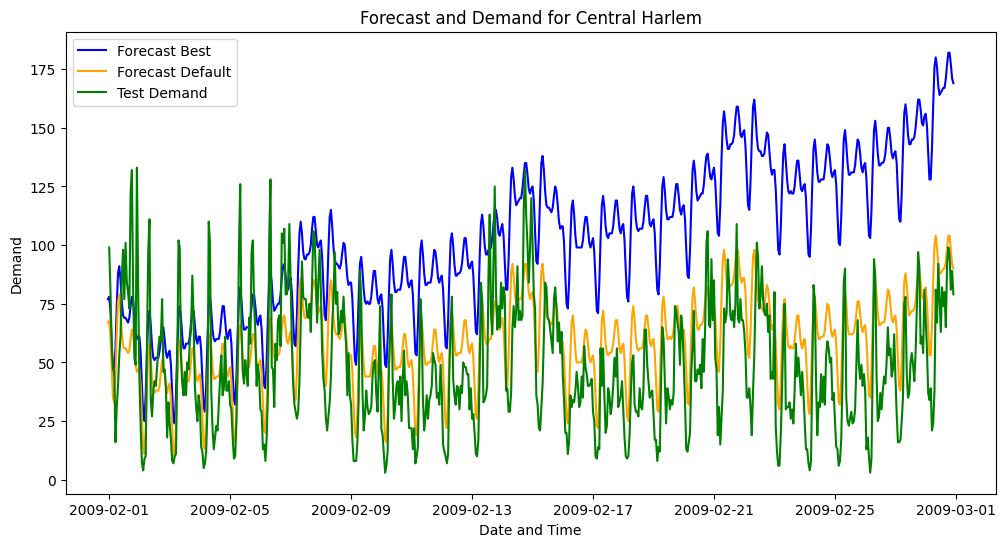

In [ ]:
# Filtern Sie die Daten für die Zone "Central Harlem"
central_harlem_data = Forecast_data[Forecast_data['Zone'] == 'Central Harlem']

# Plot the forecast and demand
plt.figure(figsize=(12, 6))
plt.plot(central_harlem_data['ds'], central_harlem_data['forecast_best'], label='Forecast Best', color='blue')
plt.plot(central_harlem_data['ds'], central_harlem_data['forecast_default'], label='Forecast Default', color='orange')
plt.plot(central_harlem_data['ds'], central_harlem_data['test_demand'], label='Test Demand', color='green')

# Customize the plot
plt.title('Forecast and Demand for Central Harlem')
plt.xlabel('Date and Time')
plt.ylabel('Demand')
plt.legend()
plt.show()

Now we calculate the weighted maped based on the demandshares of each zone, since some zones contain so little data it makes sense to weight the loss function for each zone.

Further we want to exlude Mapes of the tuned forecast which are twice as the default forecast. Lets assume for the moment this is because of to little data and will be fixed in the future when we have better computing power as Google colab and can include more data.



get demandshares

In [ ]:

def calculate_demandshares_all_zones(data):
    df = data
    total_demand = df['demand'].sum()

    # Group by 'zone' and calculate the sum of 'demand' for each zone
    result = df.groupby('zone')['demand'].sum().reset_index()

    # Calculate the percentage of 'demand' for each zone
    result['percentage'] = (result['demand'] / total_demand) * 100
    result = result.sort_values(by='percentage', ascending=False)

    # Display the result
    return result

demandshares = calculate_demandshares_all_zones(train_data)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

calculate weighted mape. Further ignore all lines where the Mape of the hypertuned forecast ist twice as the default forecast

In [ ]:

# Merge the DataFrames on the 'Zone' column
merged_df = pd.merge(prophet_evaluation, demandshares, left_on='Zone', right_on='zone', how='inner')

# Calculate the weighted MAPE values for both 'MAPE_best' and 'MAPE_default'
merged_df = merged_df[merged_df['MAPE_best'] <= 2 * merged_df['MAPE_default']]
merged_df['weighted_MAPE_best'] = merged_df['MAPE_best'] * (merged_df['percentage'] / 100)
merged_df['weighted_MAPE_default'] = merged_df['MAPE_default'] * (merged_df['percentage'] / 100)
display(merged_df)
# Sum the weighted MAPE values for each forecast type
total_weighted_MAPE_best = merged_df['weighted_MAPE_best'].sum()
total_weighted_MAPE_default = merged_df['weighted_MAPE_default'].sum()

# Calculate the overall weighted average
weighted_average_MAPE_best = total_weighted_MAPE_best / merged_df['percentage'].sum()
weighted_average_MAPE_default = total_weighted_MAPE_default / merged_df['percentage'].sum()

,Zone,Interval,MAPE_best,MAPE_default,zone,demand,percentage,weighted_MAPE_best,weighted_MAPE_default
0,Alphabet City,12H,17.785565,18.435827,Alphabet City,64217,0.495527,0.088132,0.091354
1,Battery Park,12H,45.168835,53.323182,Battery Park,4443,0.034284,0.015486,0.018281
2,Battery Park City,12H,30.757958,18.762073,Battery Park City,89803,0.692960,0.213140,0.130014
3,Bloomingdale,12H,27.740673,19.136291,Bloomingdale,42542,0.328273,0.091065,0.062819
5,Central Harlem North,12H,39.680792,20.662550,Central Harlem North,9279,0.071601,0.028412,0.014795
6,Central Park,12H,15.152836,17.776857,Central Park,180754,1.394777,0.211348,0.247948
7,Chinatown,12H,24.751107,28.161977,Chinatown,32936,0.254149,0.062905,0.071573
8,Clinton East,12H,7.403901,8.540461,Clinton East,418530,3.229562,0.239114,0.275819
9,Clinton West,12H,12.142829,12.171313,Clinton West,113762,0.877838,0.106594,0.106844
10,East Chelsea,12H,10.607467,11.242287,East Chelsea,316167,2.439684,0.258789,0.274276


In [ ]:
# Print the results
display(f"Weighted Average MAPE for 'MAPE_best': {weighted_average_MAPE_best}")
display(f"Weighted Average MAPE for 'MAPE_default': {weighted_average_MAPE_default}")
column_sum = merged_df['percentage'].sum()
display(f"Proportion of all trips included:",column_sum)

"Weighted Average MAPE for 'MAPE_best': 0.158485413377628"

"Weighted Average MAPE for 'MAPE_default': 0.16195084630286205"

'Proportion of all trips included:'

96.11758096070147

Without the outliners we still cover 96% of the data. Further steps should investigate why the mape is so high for some individual zones.
For now we assume this is fixable and the Prophet forecast an suitable model for our Taxi demand prediction!